# Forecast Hydroloelectrical power energy using ResCNN architecture

## introduction and access to data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot as aplot

import numpy as np
import pandas as pd
import math
from datetime import datetime as dt
from IPython.display import Image, HTML

from sklearn.model_selection import train_test_split

from arcgis.gis import GIS
from arcgis.learn import TimeSeriesModel, prepare_tabulardata
from arcgis.features import FeatureLayer, FeatureLayerCollection

In [2]:
gis = GIS(username = "Camendezv_UDFJC", password = "Camv07.1997!")

In [3]:
#import tables from ArcGIS online
## Capivara hydroelectric power station
Table1_HPP = gis.content.search("title:HPPCapivara* owner:camendezv_UDFJC")[0]
## Chavantes hydroelectric power station
Table2_HPP = gis.content.search("title:HPPChavantes* owner:camendezv_UDFJC")[1]
## Jurumirim hydroelectric power station
Table3_HPP = gis.content.search("title:HPPJurumirim* owner:camendezv_UDFJC")[1]

<Item title:"HPPCapivara" type:Table Layer owner:camendezv_UDFJC>
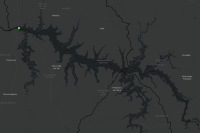

In [4]:
Table1_HPP

<Item title:"HPPChavantes" type:Table Layer owner:camendezv_UDFJC>
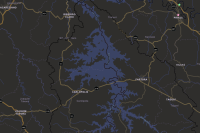

In [6]:
Table2_HPP

<Item title:"HPPJurumirim" type:Table Layer owner:camendezv_UDFJC>
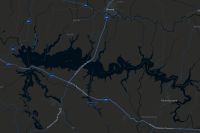

In [5]:
Table3_HPP

## Convert data into time series 

In [7]:
# Capivara
Data_Capivara = Table1_HPP.tables[0]
Series_Capivara_df = Data_Capivara.query().sdf
# Chavantes
Data_Chavantes = Table2_HPP.tables[0]
Series_Chavantes_df = Data_Chavantes.query().sdf
# Jurumirim
Data_Jurumirim = Table3_HPP.tables[0]
Series_Jurumirim_df = Data_Jurumirim.query().sdf

In [11]:
Series_Capivara_df.columns

Index(['AffluentFlow', 'DefluentFlow', 'NaturalFlow', 'AffluentNaturalEnergy',
       'Date'],
      dtype='object')

In [10]:
Series_Capivara_df = Series_Capivara_df.drop(["OBJECTID", "UsefulVolume", "UsefulVolumePercent", "StoredEnergy", "EnergyGeneration"], axis=1)
Series_Chavantes_df = Series_Chavantes_df.drop(["OBJECTID", "UsefulVolume", "UsefulVolumePercent", "StoredEnergy", "EnergyGeneration"], axis=1)
Series_Jurumirim_df = Series_Jurumirim_df.drop(["OBJECTID", "UsefulVolume", "UsefulVolumePercent", "StoredEnergy", "EnergyGeneration"], axis=1)

In [12]:
Series_Capivara_df['AffluentFlow'] = Series_Capivara_df['AffluentFlow'].astype('float64')
Series_Capivara_df['DefluentFlow'] = Series_Capivara_df['DefluentFlow'].astype('float64')
Series_Capivara_df['NaturalFlow'] = Series_Capivara_df['NaturalFlow'].astype('float64')
Series_Capivara_df['AffluentNaturalEnergy'] = Series_Capivara_df['AffluentNaturalEnergy'].astype('float64')

Series_Chavantes_df['AffluentFlow'] = Series_Chavantes_df['AffluentFlow'].astype('float64')
Series_Chavantes_df['DefluentFlow'] = Series_Chavantes_df['DefluentFlow'].astype('float64')
Series_Chavantes_df['NaturalFlow'] = Series_Chavantes_df['NaturalFlow'].astype('float64')
Series_Chavantes_df['AffluentNaturalEnergy'] = Series_Chavantes_df['AffluentNaturalEnergy'].astype('float64')

Series_Jurumirim_df['AffluentFlow'] = Series_Jurumirim_df['AffluentFlow'].astype('float64')
Series_Jurumirim_df['DefluentFlow'] = Series_Jurumirim_df['DefluentFlow'].astype('float64')
Series_Jurumirim_df['NaturalFlow'] = Series_Jurumirim_df['NaturalFlow'].astype('float64')
Series_Jurumirim_df['AffluentNaturalEnergy'] = Series_Jurumirim_df['AffluentNaturalEnergy'].astype('float64')


## Verify the information and properties of times series

In [13]:
Series_Capivara_df.info()
Series_Chavantes_df.info()
Series_Jurumirim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8521 entries, 0 to 8520
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   AffluentFlow           8521 non-null   float64       
 1   DefluentFlow           8521 non-null   float64       
 2   NaturalFlow            8521 non-null   float64       
 3   AffluentNaturalEnergy  8521 non-null   float64       
 4   Date                   8521 non-null   datetime64[us]
dtypes: datetime64[us](1), float64(4)
memory usage: 333.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8521 entries, 0 to 8520
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   AffluentFlow           8521 non-null   float64       
 1   DefluentFlow           8521 non-null   float64       
 2   NaturalFlow            8521 non-null   float64       
 3   AffluentNatura

In [14]:
Series_Capivara_df.columns

Index(['AffluentFlow', 'DefluentFlow', 'NaturalFlow', 'AffluentNaturalEnergy',
       'Date'],
      dtype='object')

## Train - Test split of timeseries dataset

### Creating dataset for validation

In [15]:
# Capivara
CapivaraPredict_df = Series_Capivara_df.copy()
CapivaraPredict_df.loc[CapivaraPredict_df["Date"] > "2019-12-31" , "AffluentNaturalEnergy"] = np.NaN

# Chavantes
ChavantesPredict_df = Series_Chavantes_df.copy()
ChavantesPredict_df.loc[ChavantesPredict_df["Date"] > "2019-12-31" , "AffluentNaturalEnergy"] = np.NaN

#Jurumirim
JurumirimPredict_df = Series_Jurumirim_df.copy()
JurumirimPredict_df.loc[JurumirimPredict_df["Date"] > "2019-12-31" , "AffluentNaturalEnergy"] = np.NaN

CapivaraPredict_df.info()
ChavantesPredict_df.info()
JurumirimPredict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8521 entries, 0 to 8520
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   AffluentFlow           8521 non-null   float64       
 1   DefluentFlow           8521 non-null   float64       
 2   NaturalFlow            8521 non-null   float64       
 3   AffluentNaturalEnergy  6939 non-null   float64       
 4   Date                   8521 non-null   datetime64[us]
dtypes: datetime64[us](1), float64(4)
memory usage: 333.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8521 entries, 0 to 8520
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   AffluentFlow           8521 non-null   float64       
 1   DefluentFlow           8521 non-null   float64       
 2   NaturalFlow            8521 non-null   float64       
 3   AffluentNatura

### Creating dataset for training

In the previous section, 5 variables were defined per hydroelectric power plant, where each variable contains 8,521 records, these measurements or records represent the daily values of the time series during the period between 2001-01-01 and 2024-04-30 (23 years and 4 months). In this order of ideas, it is necessary to define the `training`, `validation` and `forecast` datasets in order to input them to the neural network.

In [16]:
#Capivara
test_size = 1582
Train_capivara, test_capivara = train_test_split(Series_Capivara_df, test_size=test_size, shuffle=False)
#Chavantes
test_size = 1582
Train_chavantes, test_chavantes = train_test_split(Series_Chavantes_df, test_size=test_size, shuffle=False)
#Jurumirim
test_size = 1582
Train_jurumirim, test_jurumirim = train_test_split(Series_Jurumirim_df, test_size=test_size, shuffle=False)

### visualize training datasets 

In [21]:
Train_capivara.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6939 entries, 0 to 6938
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   AffluentFlow           6939 non-null   float64       
 1   DefluentFlow           6939 non-null   float64       
 2   NaturalFlow            6939 non-null   float64       
 3   AffluentNaturalEnergy  6939 non-null   float64       
 4   Date                   6939 non-null   datetime64[us]
dtypes: datetime64[us](1), float64(4)
memory usage: 325.3 KB


### Checking autocorrelation of time dependent variables

#### Capivara hydroelectric power station

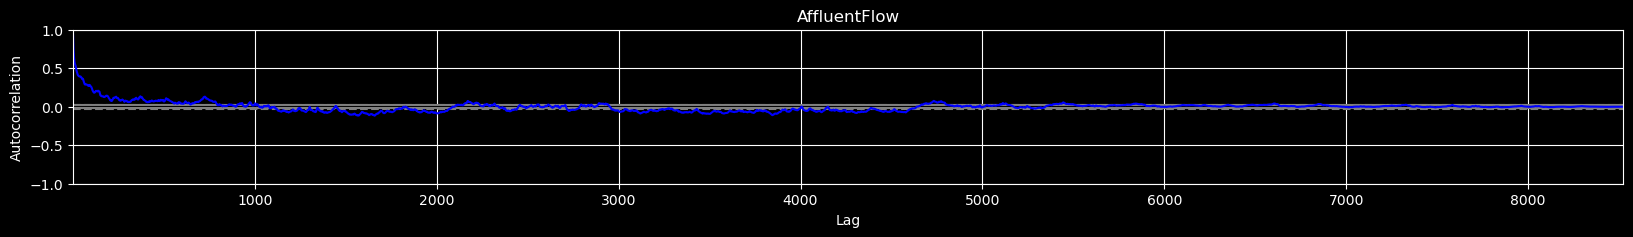

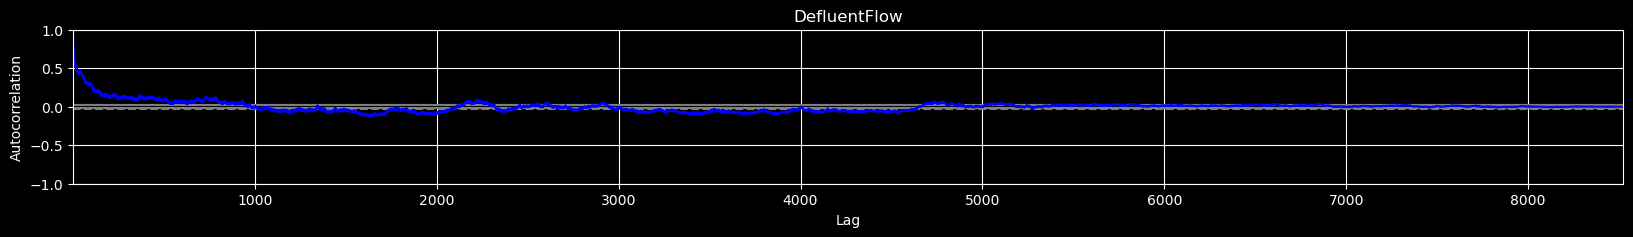

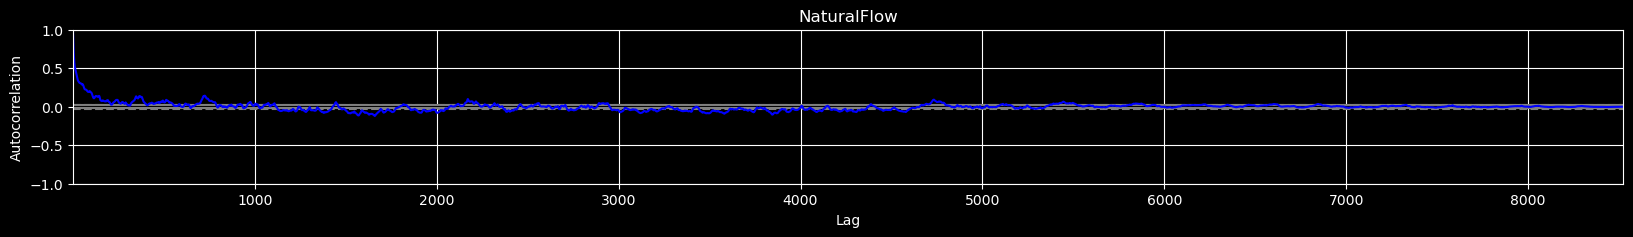

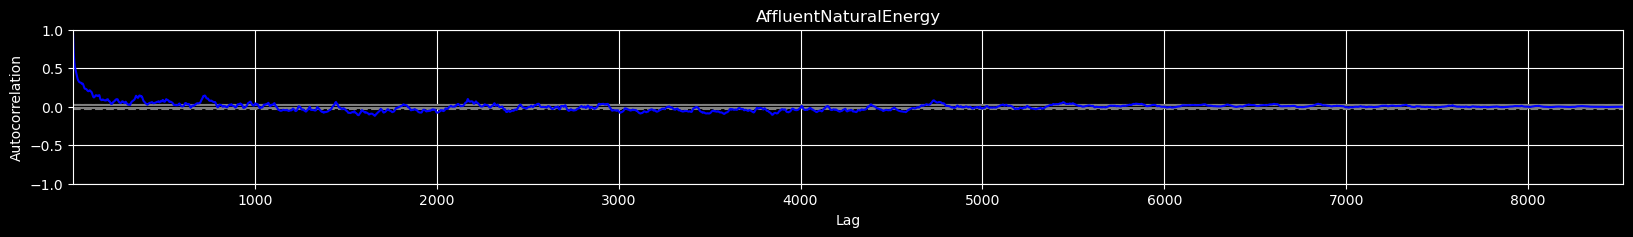

In [22]:
variables = ["AffluentFlow", "DefluentFlow", "NaturalFlow", "AffluentNaturalEnergy"]
for variable in variables:
    plt.figure(figsize=(20, 2))
    autocorr = aplot(Series_Capivara_df[variable], color="blue")
    plt.title(variable)

#### Chavantes hydroelectric power station

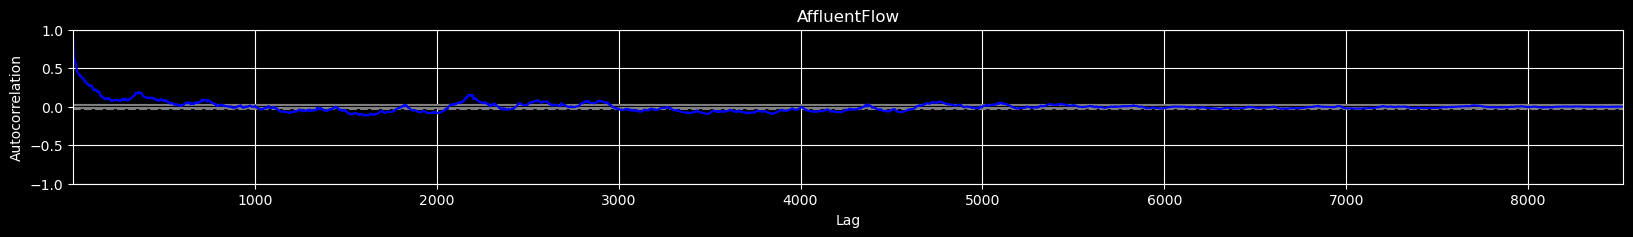

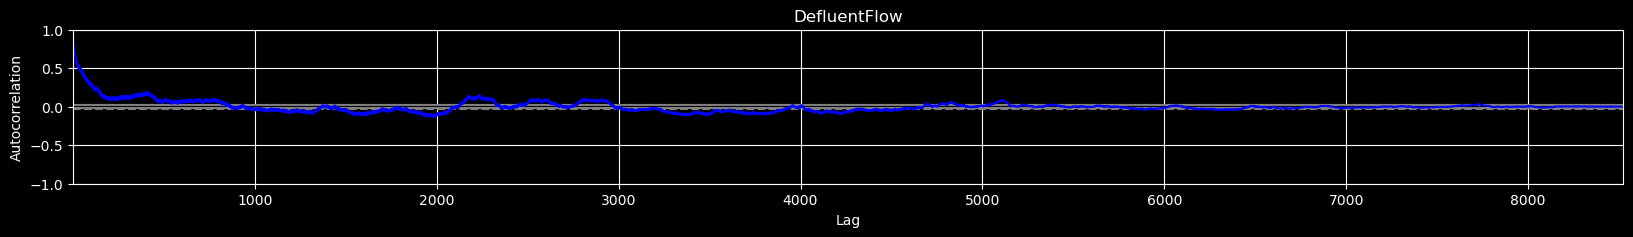

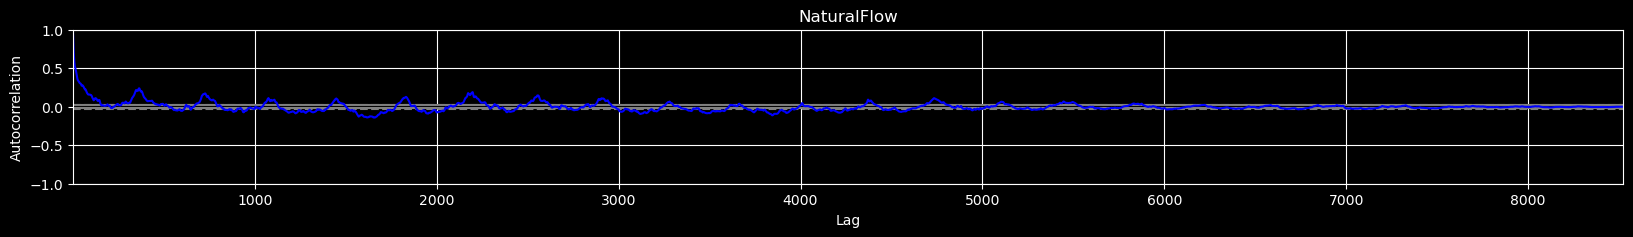

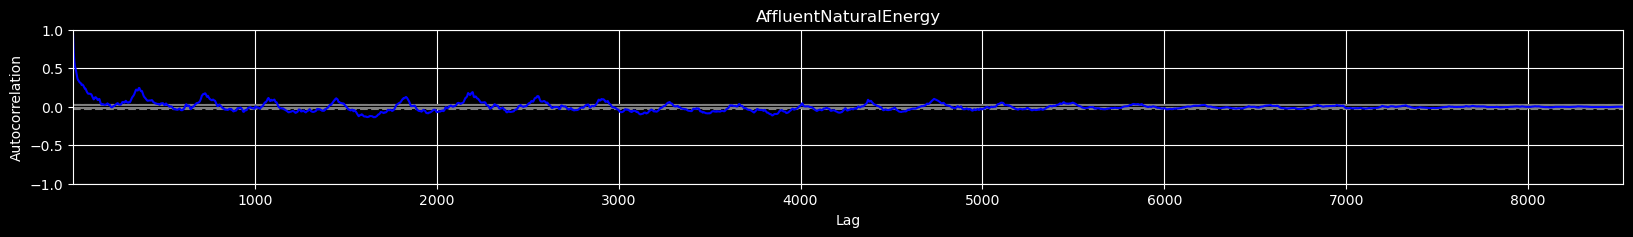

In [23]:
variables = ["AffluentFlow", "DefluentFlow", "NaturalFlow", "AffluentNaturalEnergy"]
for variable in variables:
    plt.figure(figsize=(20, 2))
    autocorr = aplot(Series_Chavantes_df[variable], color="blue")
    plt.title(variable)

#### Jurumirim hydroelectric power station

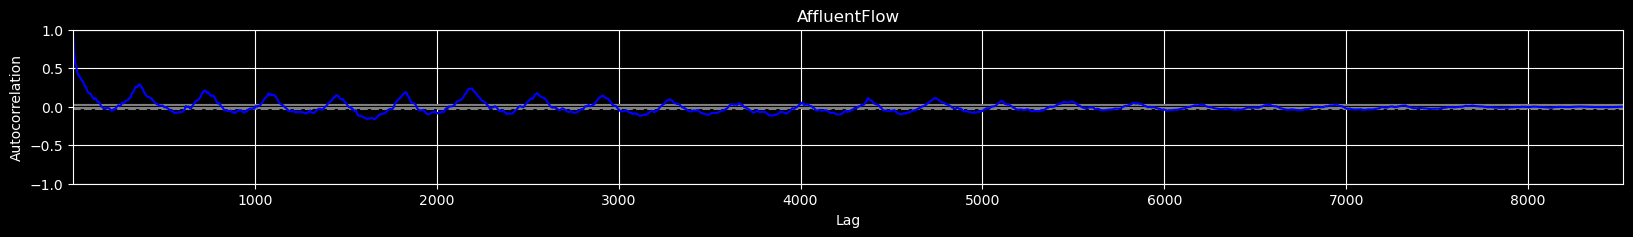

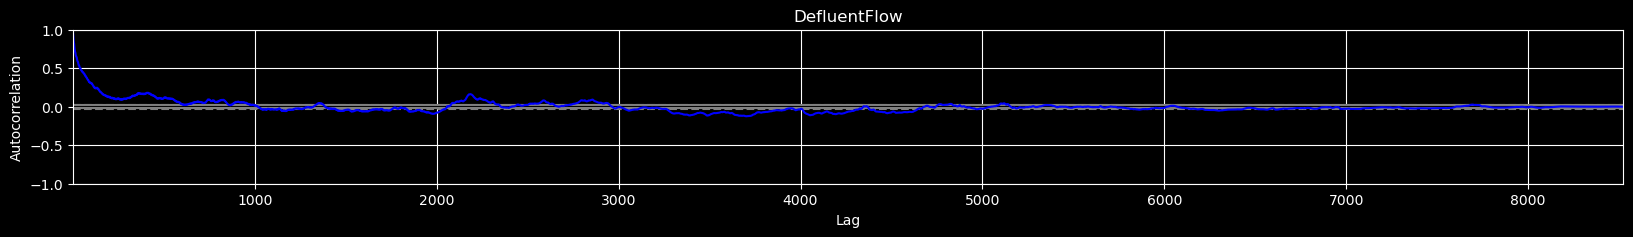

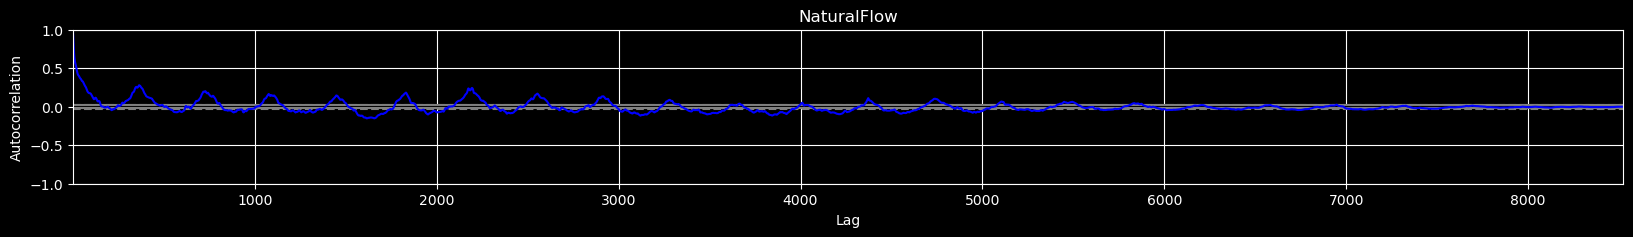

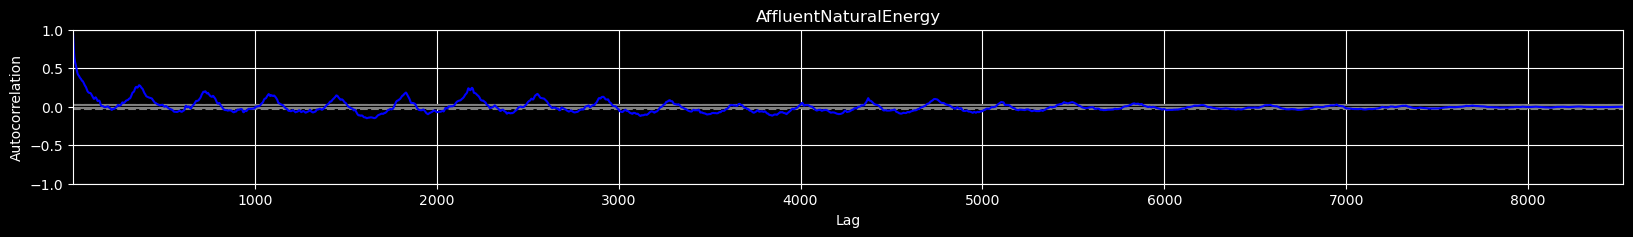

In [24]:
variables = ["AffluentFlow", "DefluentFlow", "NaturalFlow", "AffluentNaturalEnergy"]
for variable in variables:
    plt.figure(figsize=(20, 2))
    autocorr = aplot(Series_Jurumirim_df[variable], color="blue")
    plt.title(variable)

## Time series model building

### Data preprocessing

In [25]:
data_capivara = prepare_tabulardata(
    Train_capivara,
    variable_predict="AffluentNaturalEnergy",
    explanatory_variables=["AffluentFlow", "DefluentFlow", "NaturalFlow"],
    index_field="Date"
)

data_chavantes = prepare_tabulardata(
    Train_chavantes,
    variable_predict="AffluentNaturalEnergy",
    explanatory_variables=["AffluentFlow", "DefluentFlow", "NaturalFlow"],
    index_field="Date"
)

data_jurumirim = prepare_tabulardata(
    Train_jurumirim,
    variable_predict="AffluentNaturalEnergy",
    explanatory_variables=["AffluentFlow", "DefluentFlow", "NaturalFlow"],
    index_field="Date"
)

C:\Users\57320\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\arcgis\learn\models\_arcgis_model.py:461: UserWarning:

Cuda is not available

C:\Users\57320\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\arcgis\learn\_utils\tabular_data.py:1871: UserWarning:

Dataframe is not spatial, Rasters and distance layers will not work

C:\Users\57320\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\arcgis\learn\_utils\tabular_data.py:1871: UserWarning:

Dataframe is not spatial, Rasters and distance layers will not work

C:\Users\57320\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\arcgis\learn\_utils\tabular_data.py:1871: UserWarning:

Dataframe is not spatial, Rasters and distance layers will not work



### Plot the time series by hydroelectric power station

#### Capivara 

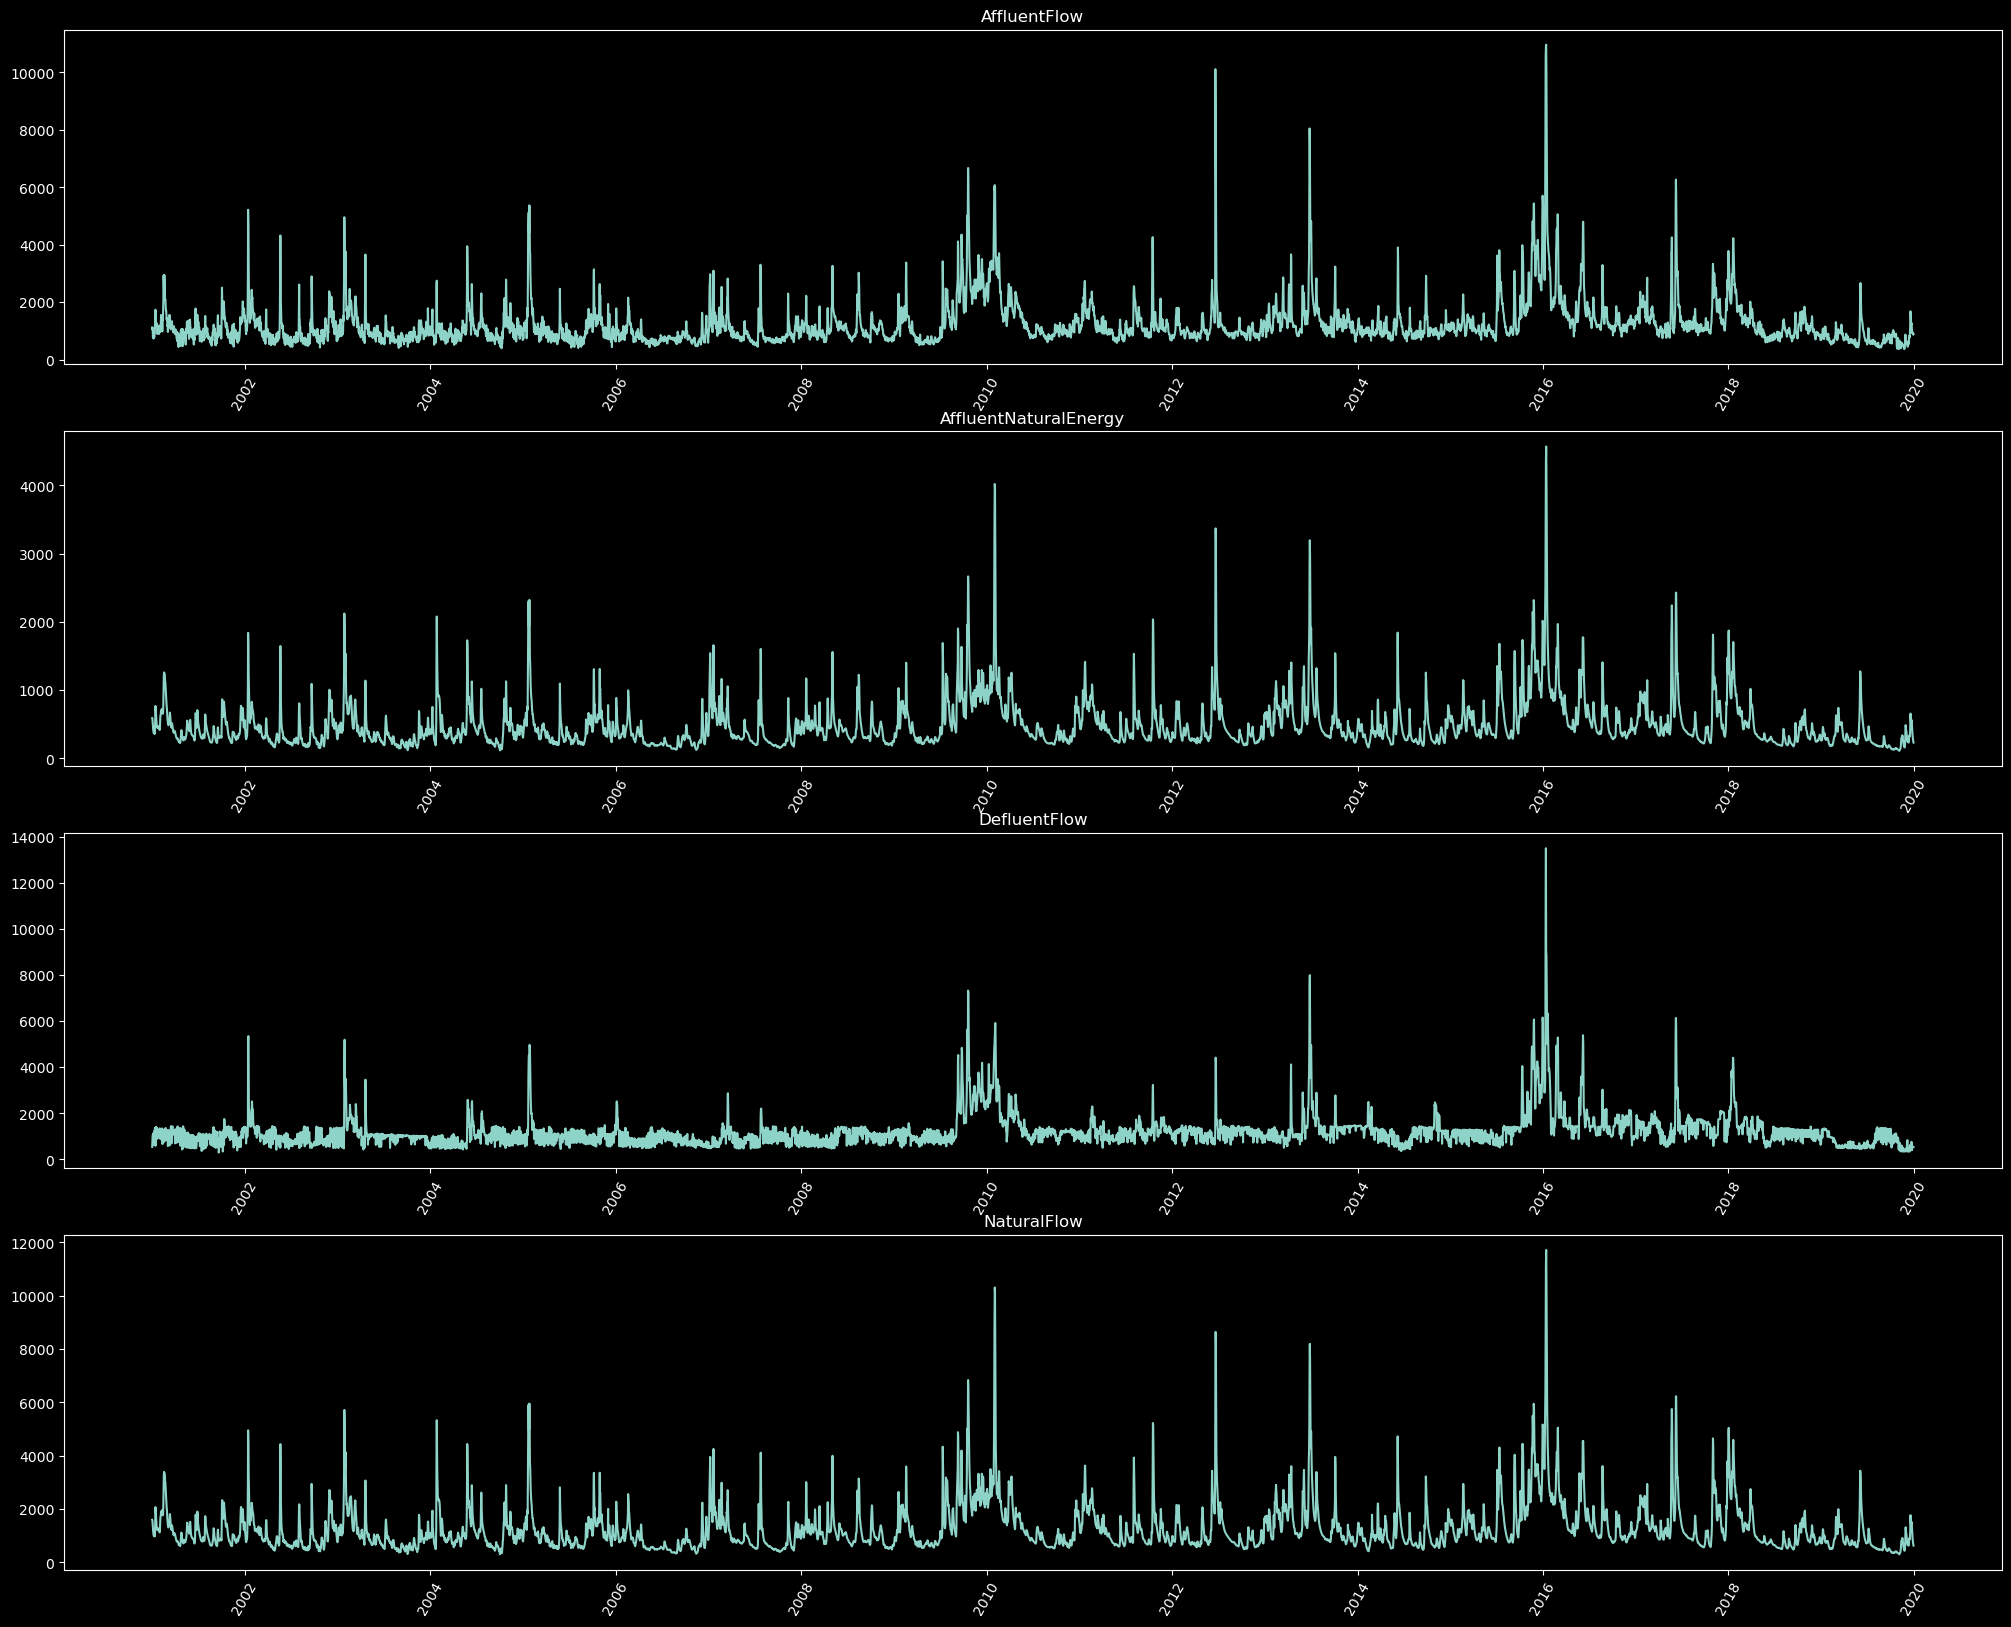

In [26]:
# Visualize the entire timeseries data
data_capivara.show_batch(graph=True)

#### Chavantes 

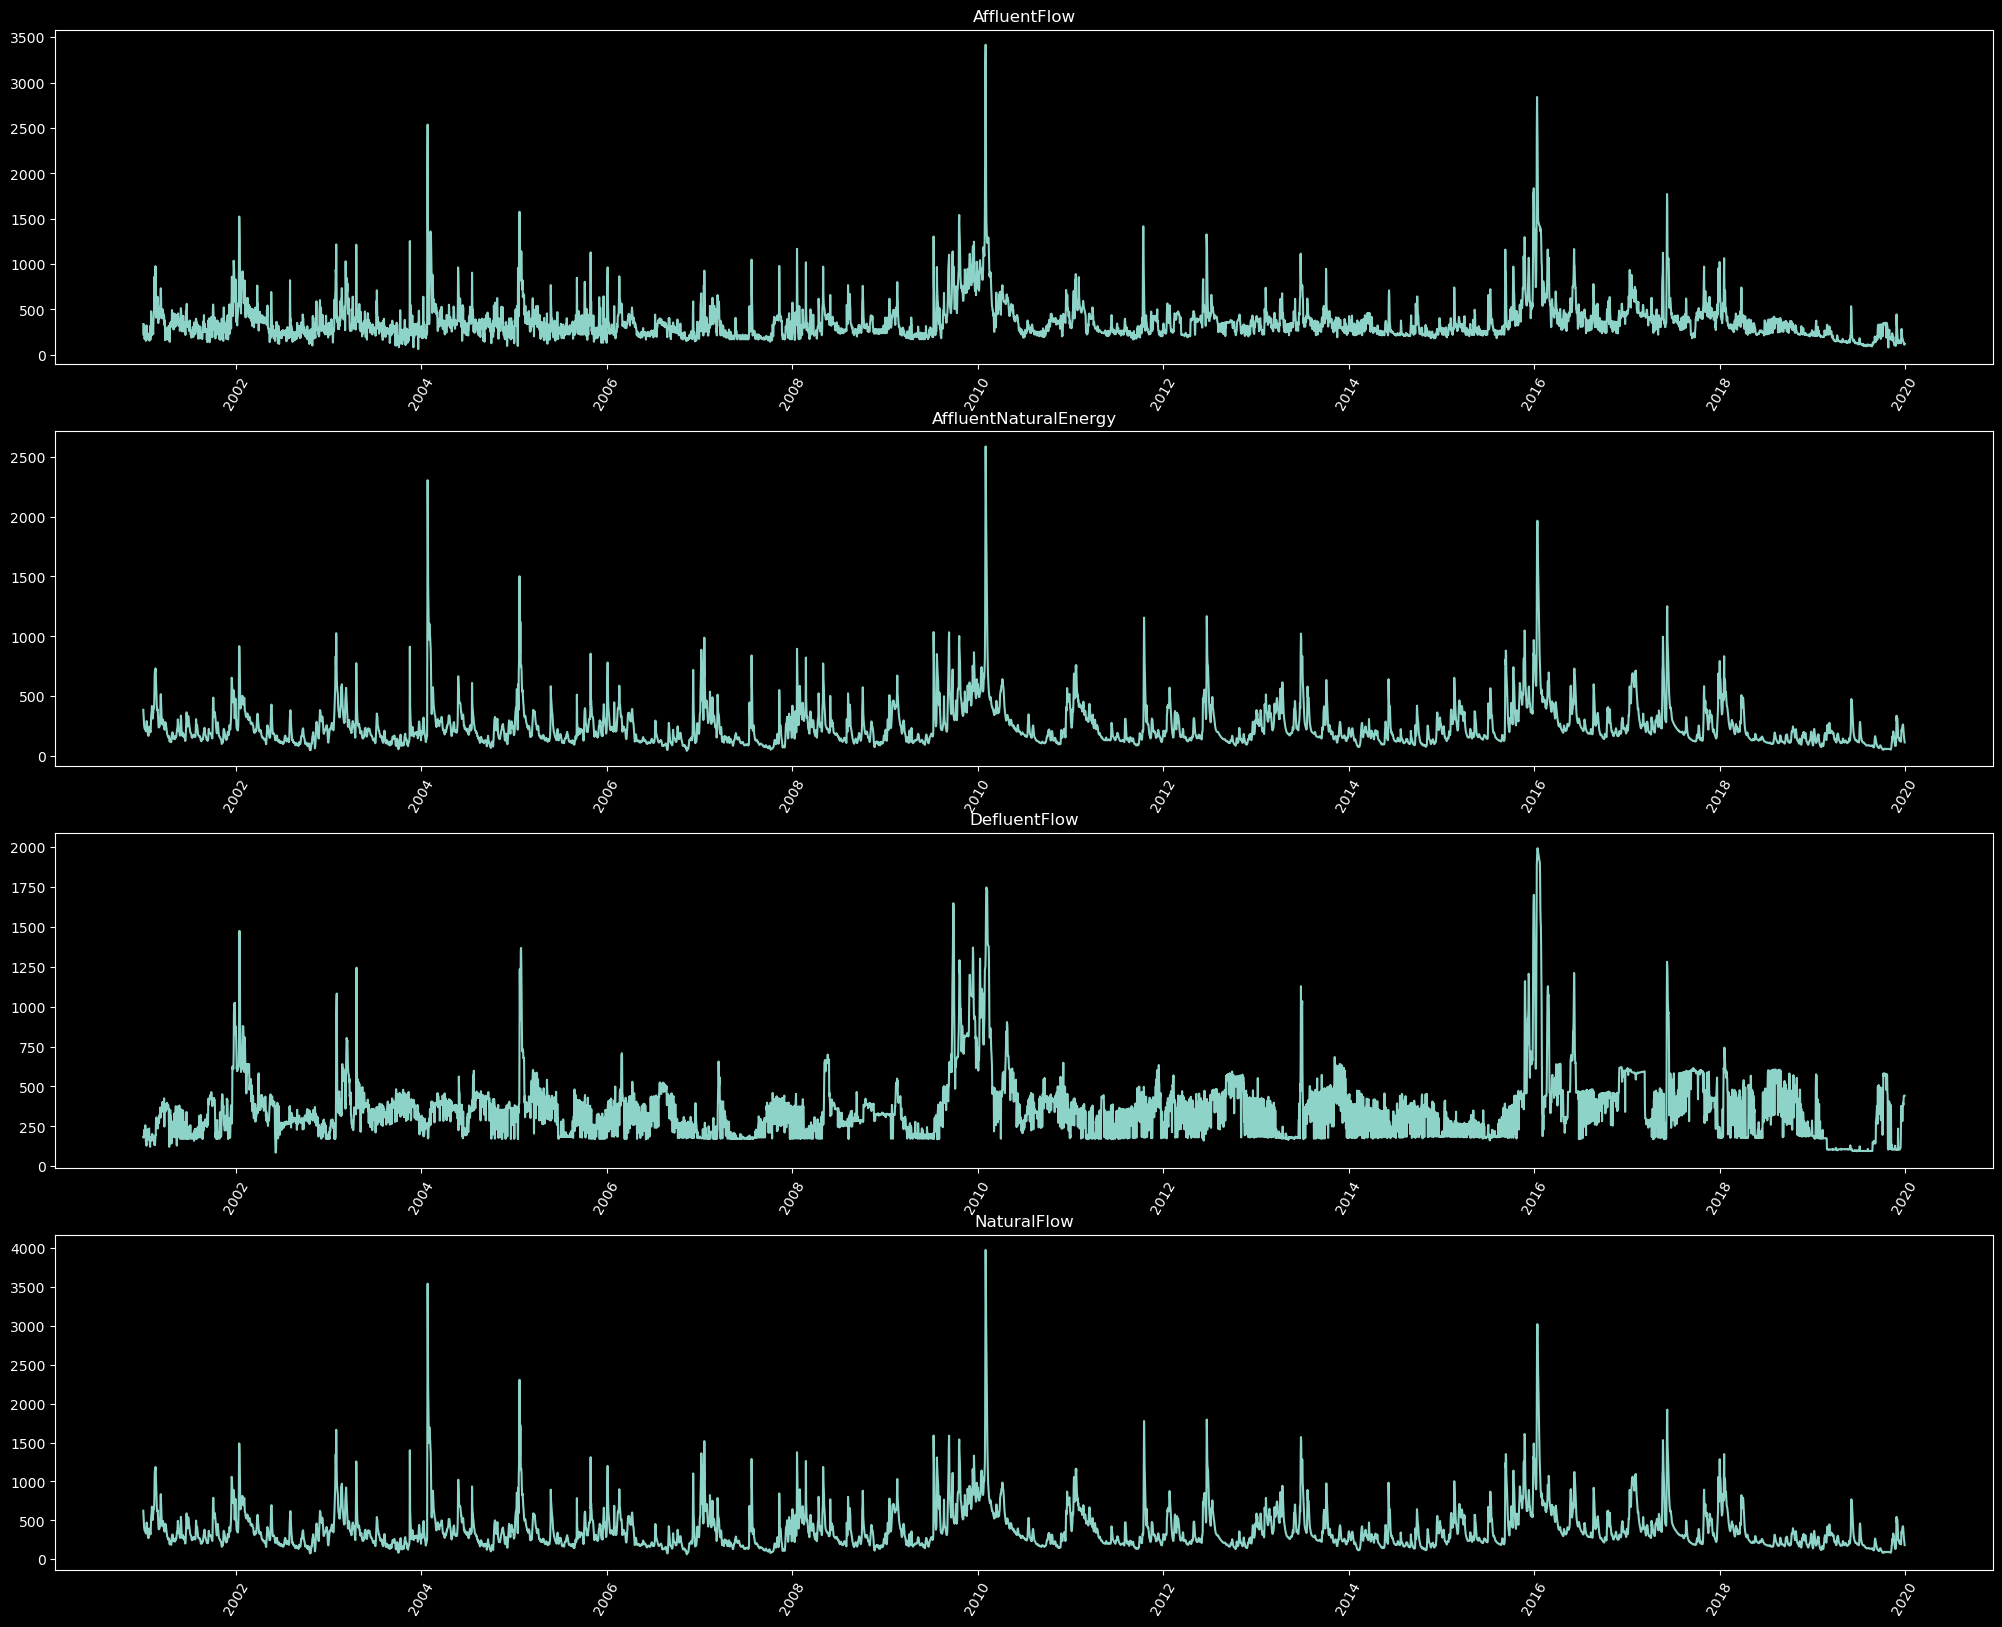

In [27]:
# Visualize the entire timeseries data
data_chavantes.show_batch(graph=True)

#### Jurumirim 

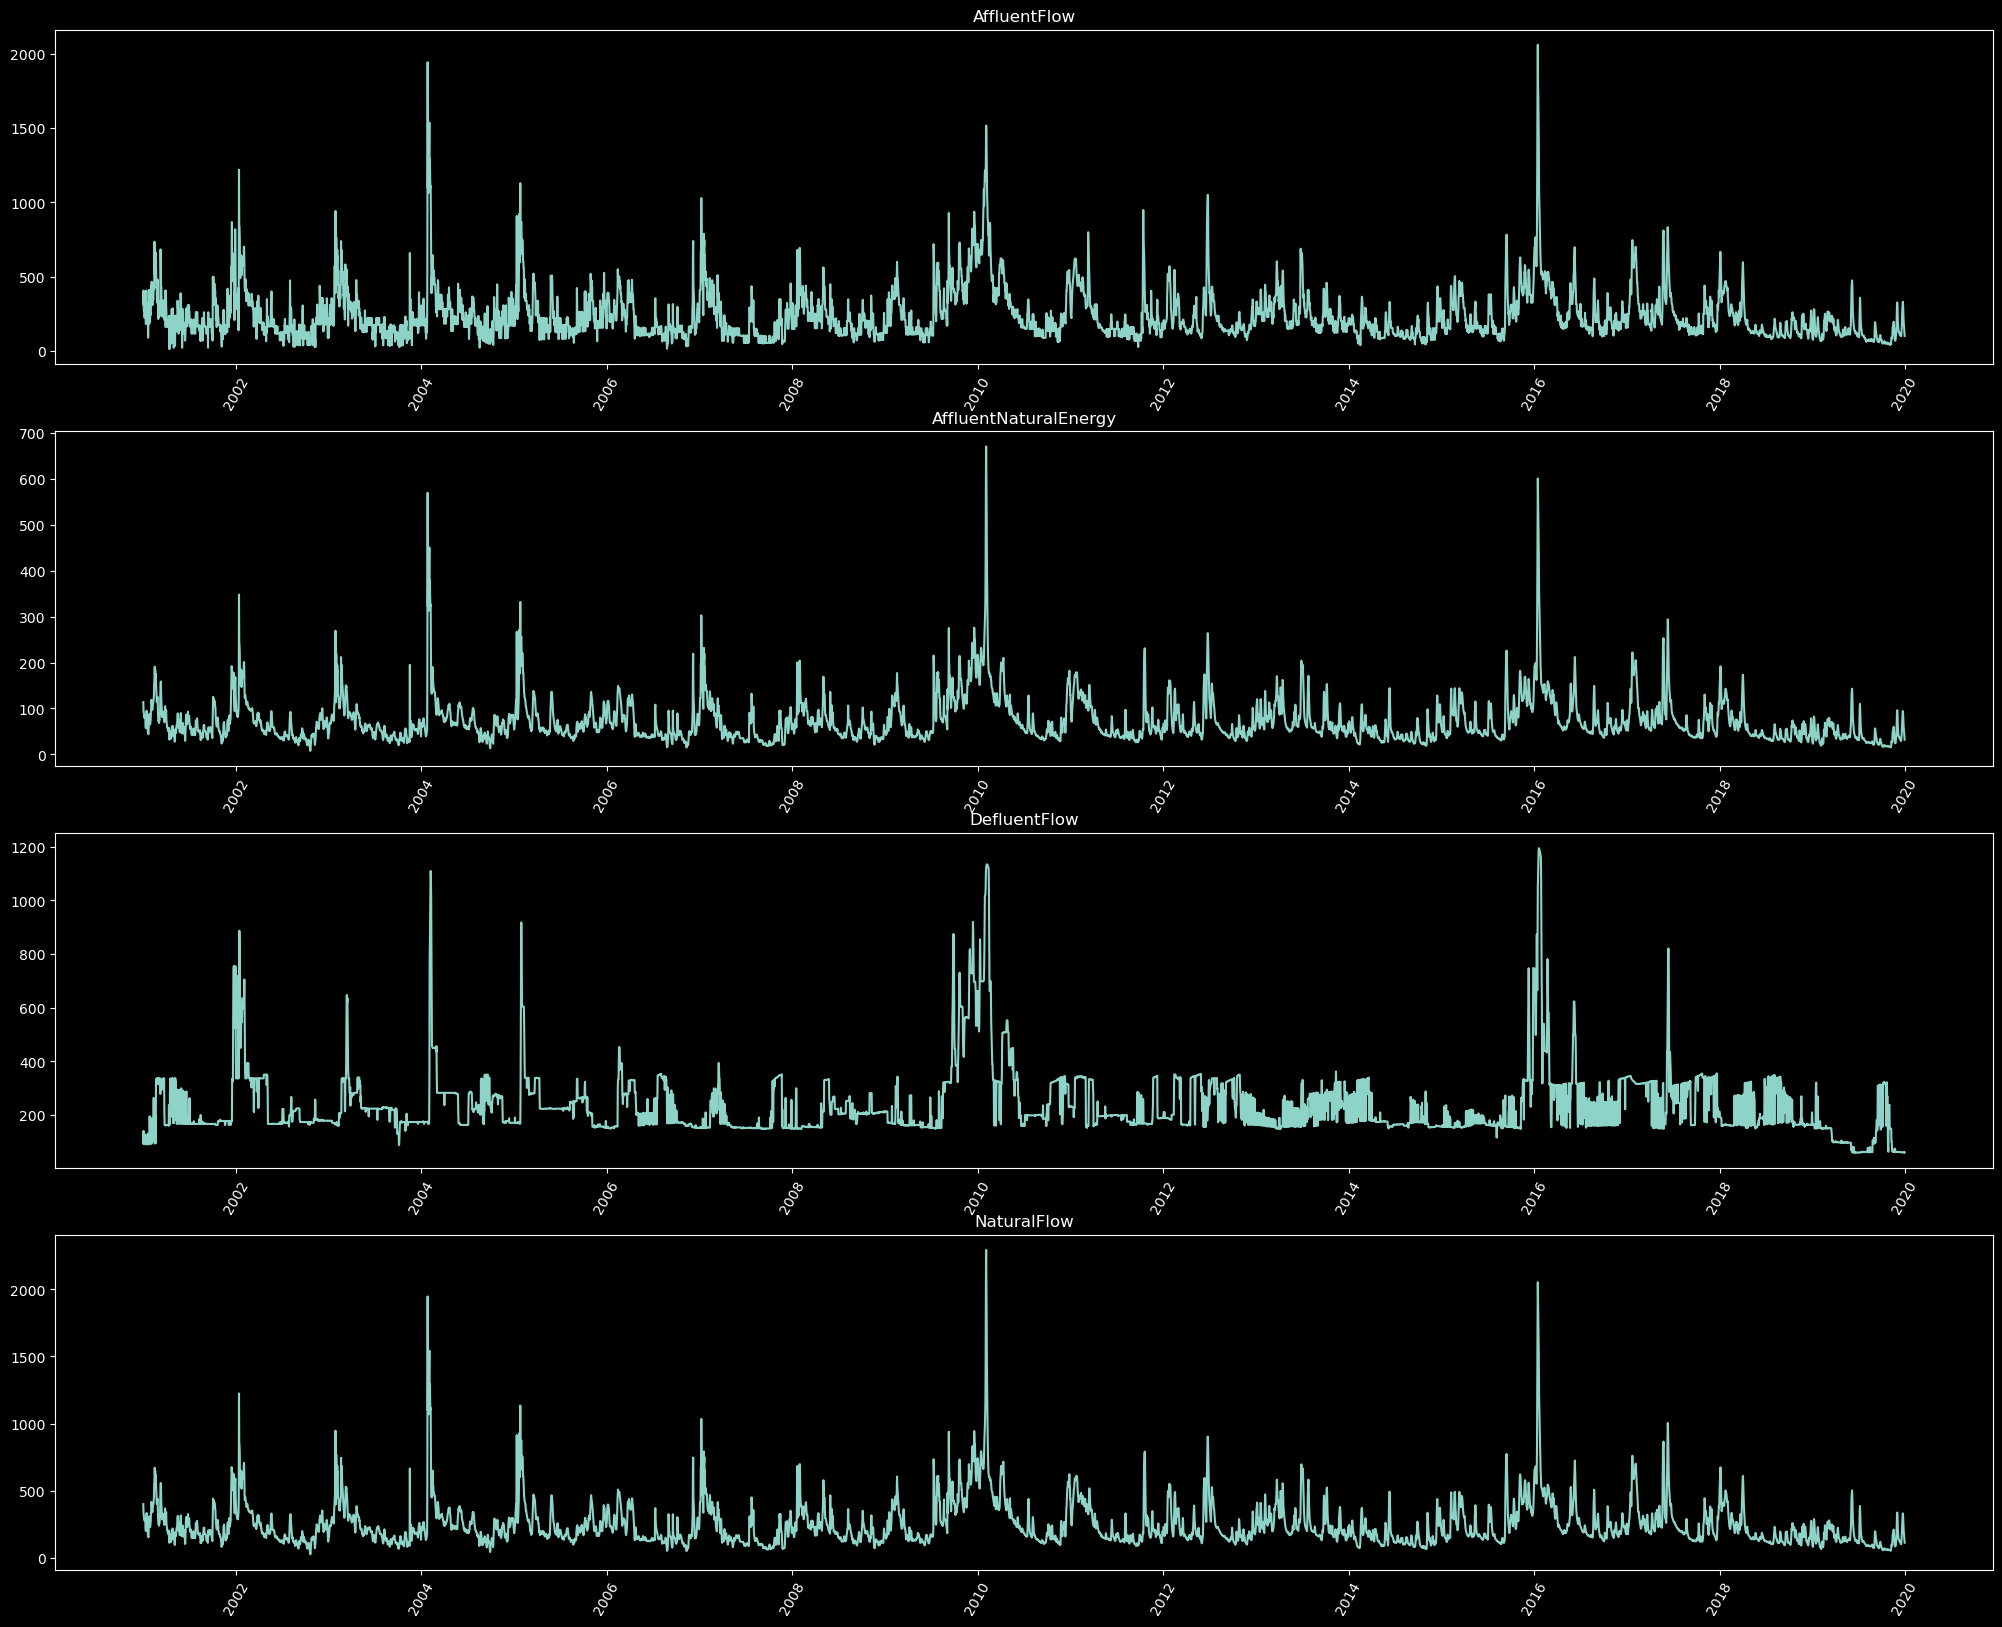

In [28]:
# Visualize the entire timeseries data
data_jurumirim.show_batch(graph=True)

### Compare the Affluent Flow, Stored Energy and Affluent Natural Energy

In [29]:
# Here sequence length is used as 12 which also indicates the seasonality of the data
seq_len = 365

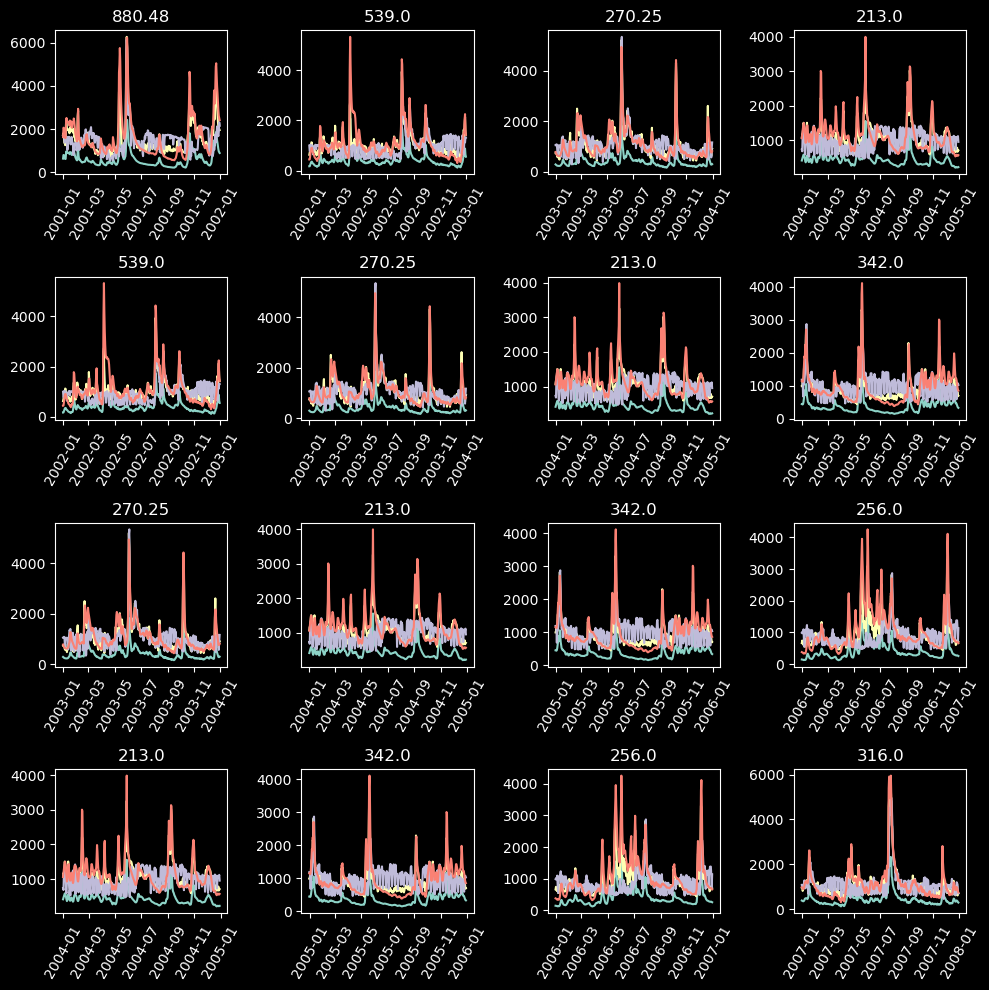

In [30]:
data_capivara.show_batch(rows=4, seq_len=seq_len)

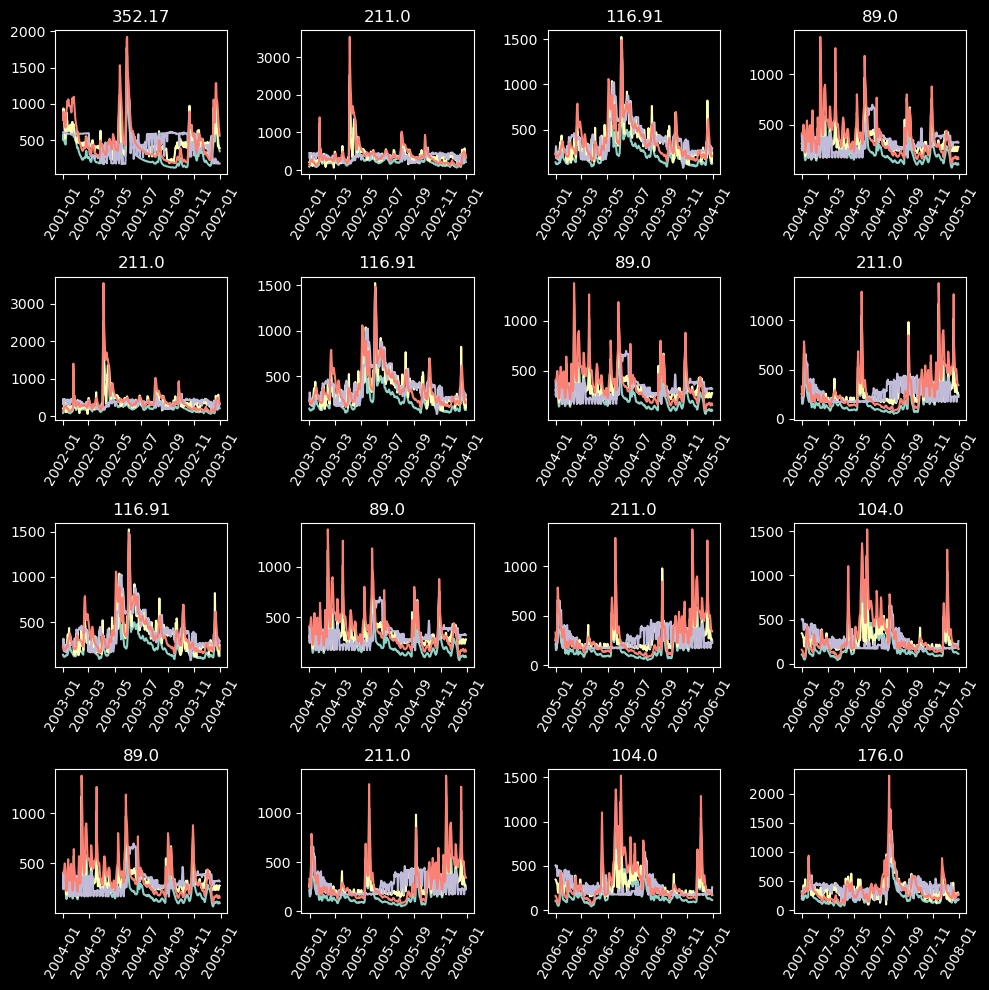

In [31]:
data_chavantes.show_batch(rows=4, seq_len=seq_len)

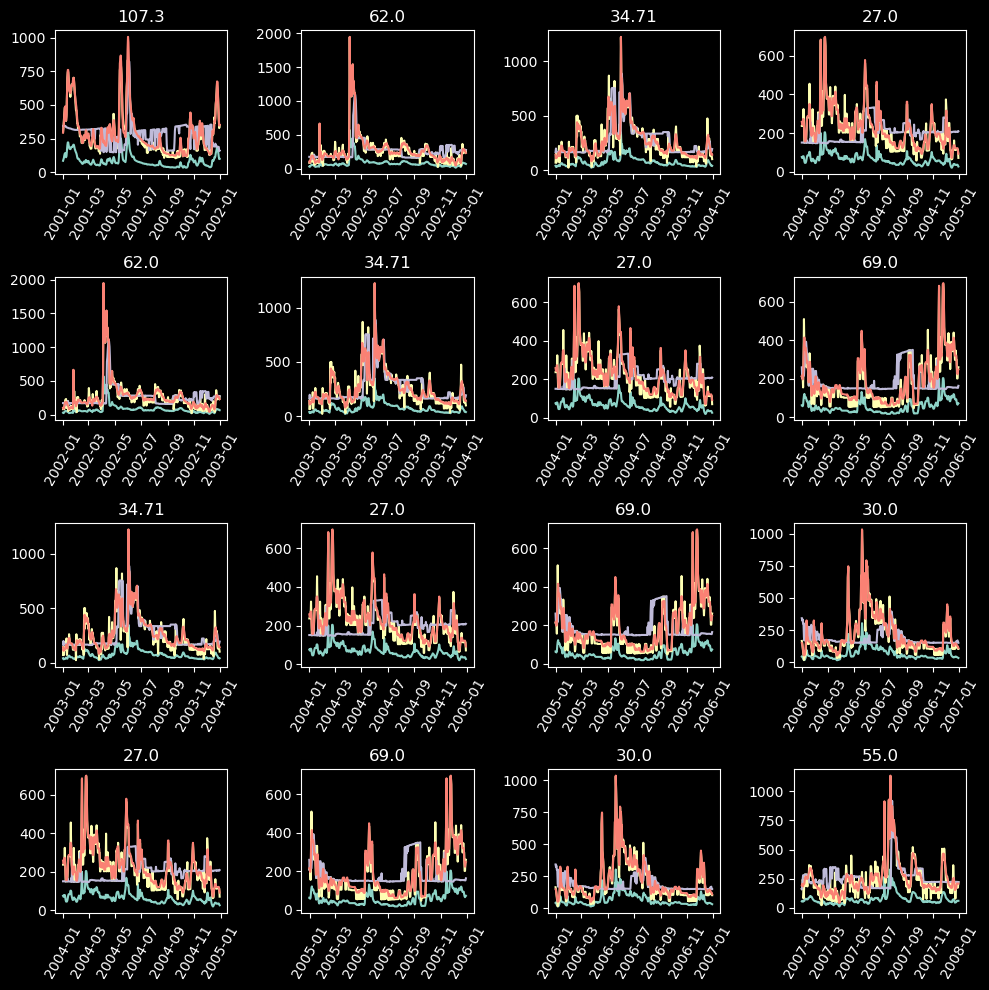

In [32]:
data_jurumirim.show_batch(rows=4, seq_len=seq_len)

### Model initialization

#### Capivara

In [33]:
tsmodel_capivara = TimeSeriesModel(data_capivara, seq_len=seq_len, model_arch="ResCNN")

#### Chavantes 

In [34]:
tsmodel_chavantes = TimeSeriesModel(data_chavantes, seq_len=seq_len, model_arch="ResCNN")

#### Jurumirim 

In [35]:
tsmodel_jurumirim = TimeSeriesModel(data_jurumirim, seq_len=seq_len, model_arch="ResCNN")

## Learning rate search 

Here, we find the optimal learning rate for training the model.

### Capivara 

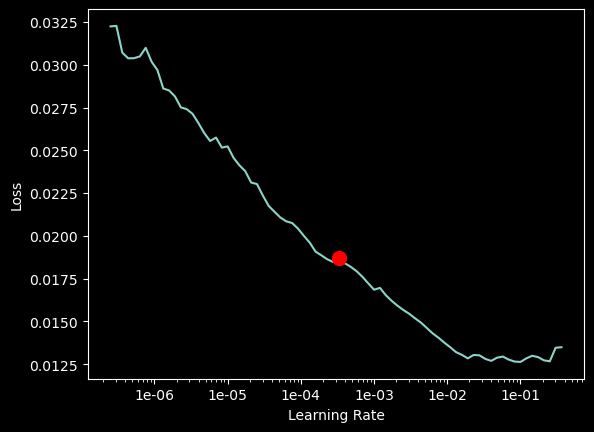

0.0003311311214825911

In [36]:
lr_rate_capivara = tsmodel_capivara.lr_find()
lr_rate_capivara

### Chavantes 

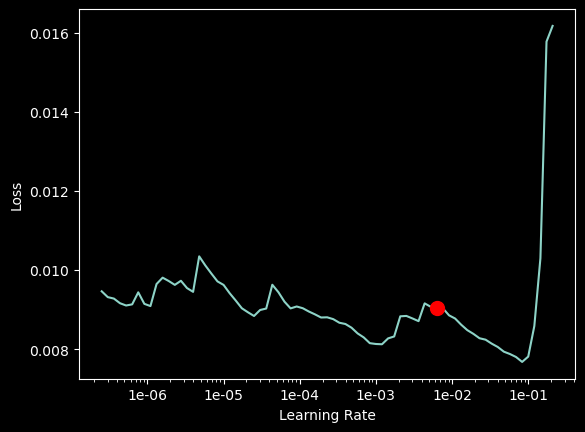

0.006309573444801929

In [37]:
lr_rate_chavantes = tsmodel_chavantes.lr_find()
lr_rate_chavantes

### Jurumirim 

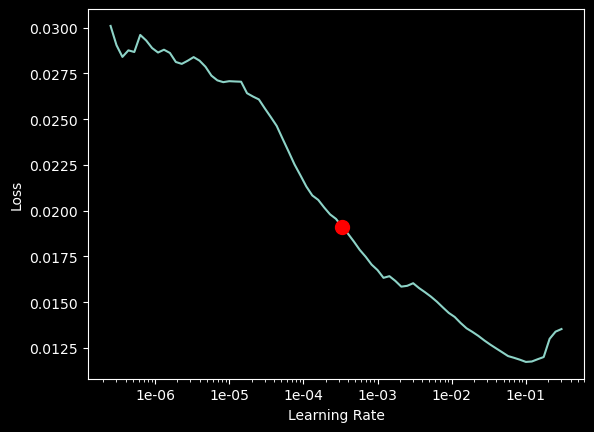

0.0003311311214825911

In [38]:
lr_rate_jurumirim = tsmodel_jurumirim.lr_find()
lr_rate_jurumirim

## Model training  

### Capivara 

In [39]:
tsmodel_capivara.fit(30, lr=lr_rate_capivara)

epoch     train_loss  valid_loss  time    
0         0.006205    0.004677    01:14     
1         0.004684    0.003906    01:15     
2         0.003175    0.001855    01:16     
3         0.001795    0.002350    01:16     
4         0.001448    0.000802    01:15     
5         0.001195    0.001658    01:18     
6         0.000926    0.000465    01:15     
7         0.000922    0.000612    01:16     
8         0.000747    0.001364    01:15     
9         0.000744    0.000682    01:15     
10        0.000585    0.000419    01:15     
11        0.000609    0.000379    01:16     
12        0.000557    0.000789    01:16     
13        0.000541    0.000938    01:15     
14        0.000576    0.000290    01:12     
15        0.000451    0.000401    01:13     
16        0.000451    0.001752    01:10     
17        0.000418    0.000282    01:12     
18        0.000414    0.000259    01:12     
19        0.000391    0.000265    01:12     
20        0.000391    0.000289    01:12     
21        0.

C:\Users\57320\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\fastai\sixel.py:16: UserWarning:

You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel



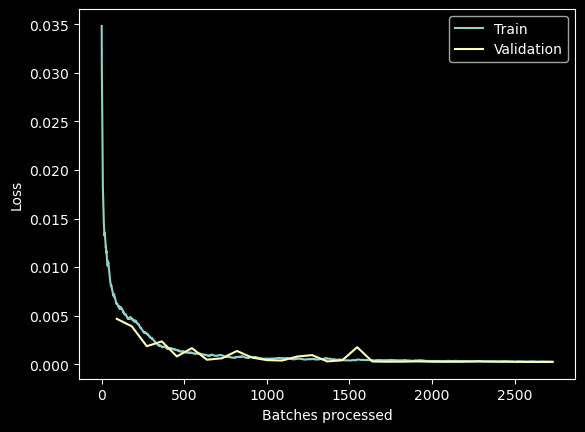

In [40]:
tsmodel_capivara.plot_losses()

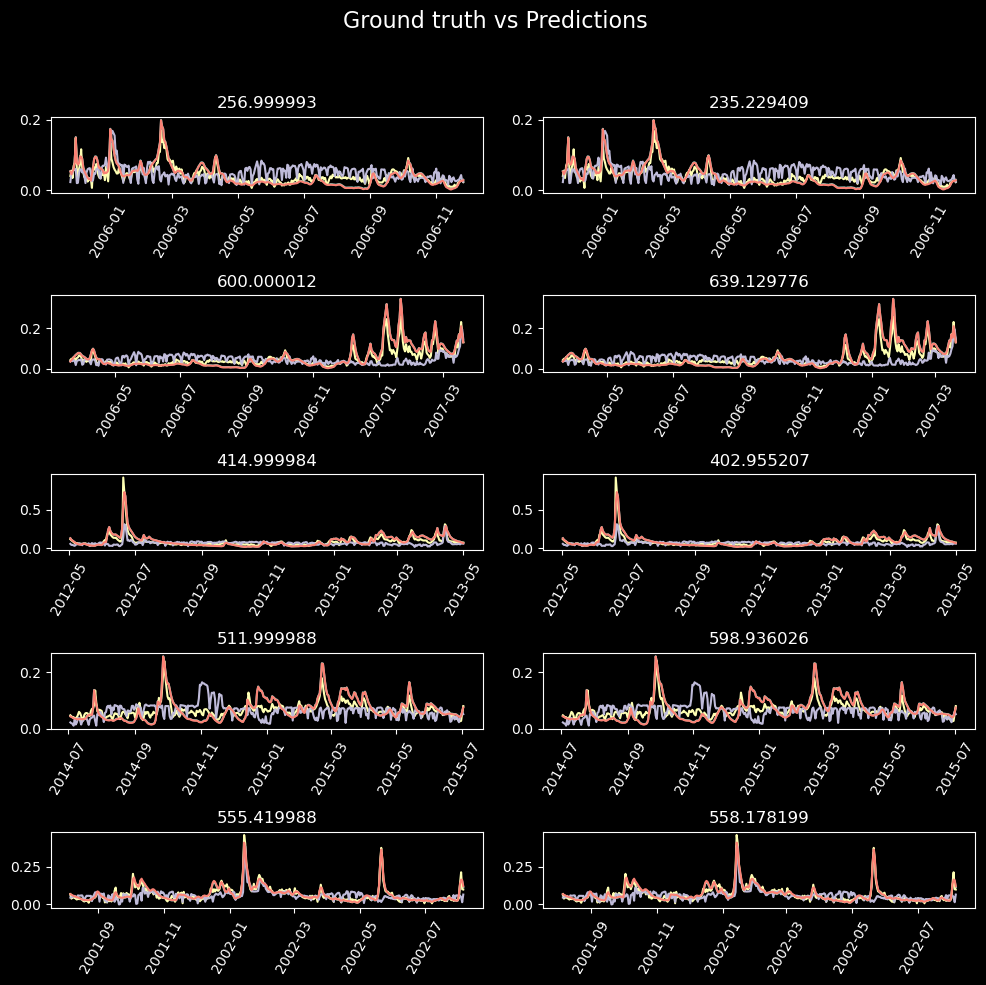

In [41]:
tsmodel_capivara.show_results(rows=5)

### Chavantes 

In [42]:
tsmodel_chavantes.fit(30, lr=lr_rate_chavantes)

epoch     train_loss  valid_loss  time    
0         0.004978    0.006283    01:47     
1         0.002984    0.014524    01:46     
2         0.001736    0.000603    01:45     
3         0.001228    0.010686    01:45     
4         0.001206    0.004573    01:50     
5         0.001001    0.000340    01:45     
6         0.000880    0.000296    01:45     
7         0.000887    0.000339    01:52     
8         0.000923    0.001804    01:44     
9         0.000728    0.000287    01:45     
10        0.000857    0.000359    01:44     
11        0.000808    0.001573    01:44     
12        0.000724    0.000514    01:43     
13        0.000698    0.000564    01:43     
14        0.000625    0.000719    01:43     
15        0.000688    0.000783    01:43     
16        0.000639    0.000353    01:43     
17        0.000571    0.000288    01:50     
18        0.000508    0.000261    01:44     
19        0.000577    0.000618    01:43     
20        0.000586    0.000268    01:43     
21        0.

C:\Users\57320\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\fastai\sixel.py:16: UserWarning:

You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel



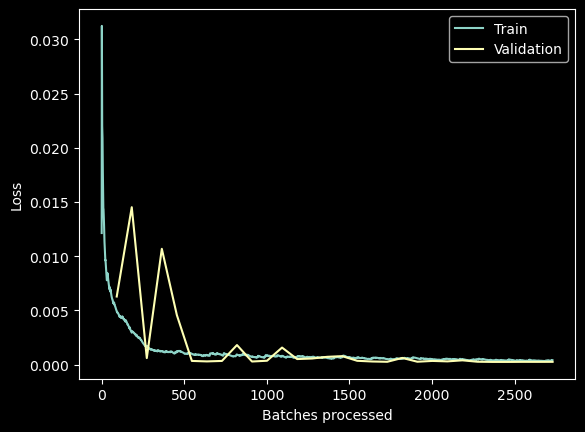

In [43]:
tsmodel_chavantes.plot_losses()

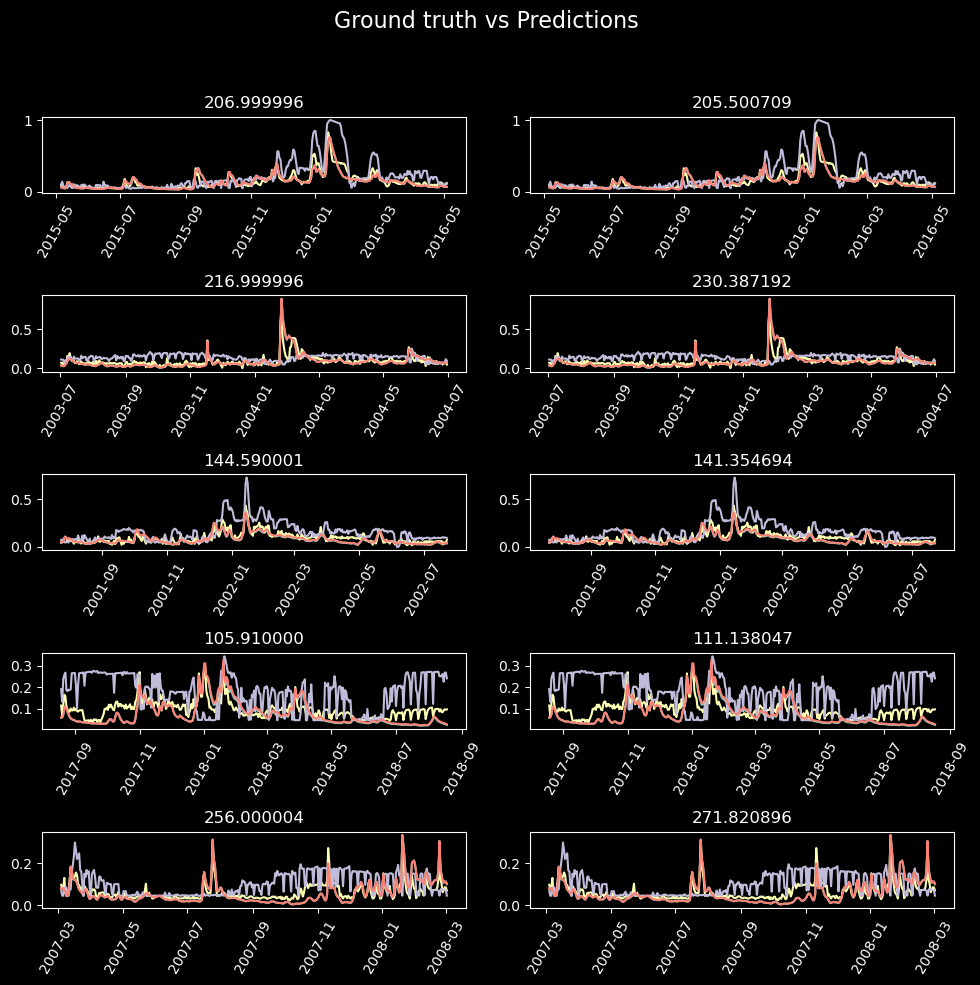

In [44]:
tsmodel_chavantes.show_results(rows=5)

### Jurumirim 

In [45]:
tsmodel_jurumirim.fit(30, lr=lr_rate_jurumirim)

epoch     train_loss  valid_loss  time    
0         0.006400    0.003872    02:02     
1         0.004370    0.003709    01:54     
2         0.002789    0.001121    01:55     
3         0.001836    0.000826    01:53     
4         0.001470    0.001451    01:54     
5         0.001314    0.001077    01:52     
6         0.000949    0.001177    01:53     
7         0.001004    0.002438    02:14     
8         0.000884    0.000547    02:01     
9         0.000705    0.000463    01:59     
10        0.000733    0.000471    02:02     
11        0.000654    0.000357    02:15     
12        0.000560    0.000413    01:55     
13        0.000659    0.000529    01:58     
14        0.000612    0.000426    02:06     
15        0.000450    0.000362    01:48     
16        0.000494    0.000436    01:30     
17        0.000496    0.000539    01:34     
18        0.000485    0.000964    01:24     
19        0.000423    0.000449    02:17     
20        0.000385    0.000393    01:28     
21        0.

C:\Users\57320\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\fastai\sixel.py:16: UserWarning:

You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel



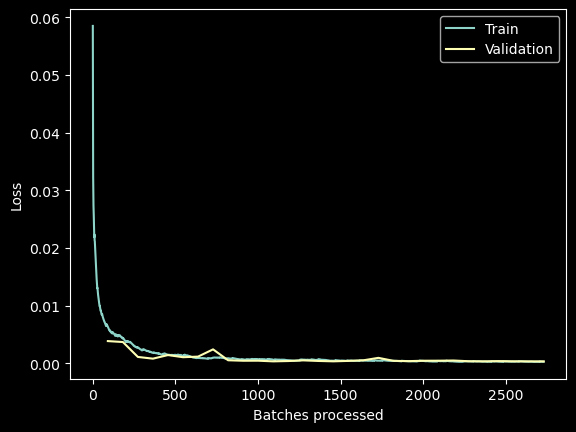

In [46]:
tsmodel_jurumirim.plot_losses()

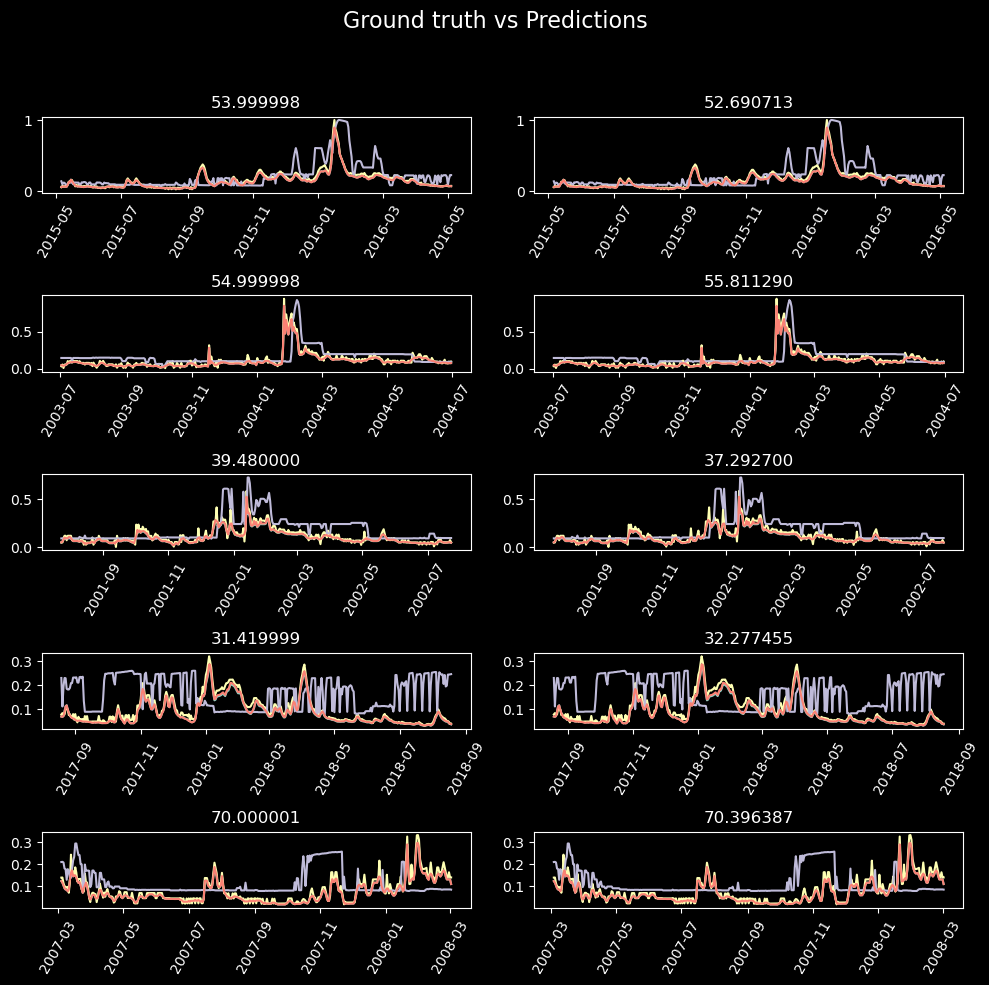

In [47]:
tsmodel_jurumirim.show_results(rows=5)

## Energy Generation forecast & validation  

### Forecasting using the trained TimeSeriesModel 

In [54]:
#Capivara
df_forecasted_capivara = tsmodel_capivara.predict(CapivaraPredict_df, prediction_type="dataframe")
#Chavantes
df_forecasted_chavantes = tsmodel_chavantes.predict(ChavantesPredict_df, prediction_type="dataframe")
#Jurumirim
df_forecasted_jurumirim = tsmodel_capivara.predict(JurumirimPredict_df, prediction_type="dataframe")

In [138]:
print(df_forecasted_capivara)
print(df_forecasted_chavantes)
print(df_forecasted_jurumirim)

      AffluentFlow  DefluentFlow  ...       Date  AffluentNaturalEnergy_results
0          1115.00         541.0  ... 2001-01-01                     591.400000
1          1046.86         759.0  ... 2001-01-02                     581.630000
2          1099.64        1042.0  ... 2001-01-03                     521.180000
3           787.02        1075.0  ... 2001-01-04                     466.780000
4           952.49        1125.0  ... 2001-01-05                     426.140000
...            ...           ...  ...        ...                            ...
8516        411.96         305.0  ... 2024-04-26                     267.344702
8517        447.05         340.0  ... 2024-04-27                     249.443587
8518        464.75         304.0  ... 2024-04-28                     244.408467
8519        457.39         511.0  ... 2024-04-29                     249.194446
8520        439.61         386.0  ... 2024-04-30                     255.850525

[8521 rows x 6 columns]
      AffluentF

## Compare actual vs predicted results.

In [143]:
result_capivara_df = pd.DataFrame()
result_capivara_df["Date"] = Series_Chavantes_df["Date"]
result_capivara_df["AffluentNaturalEnergy_actual"] = Series_Capivara_df["AffluentNaturalEnergy"]
result_capivara_df["AffluentNaturalEnergy_predicted"] = df_forecasted_capivara["AffluentNaturalEnergy_results"]

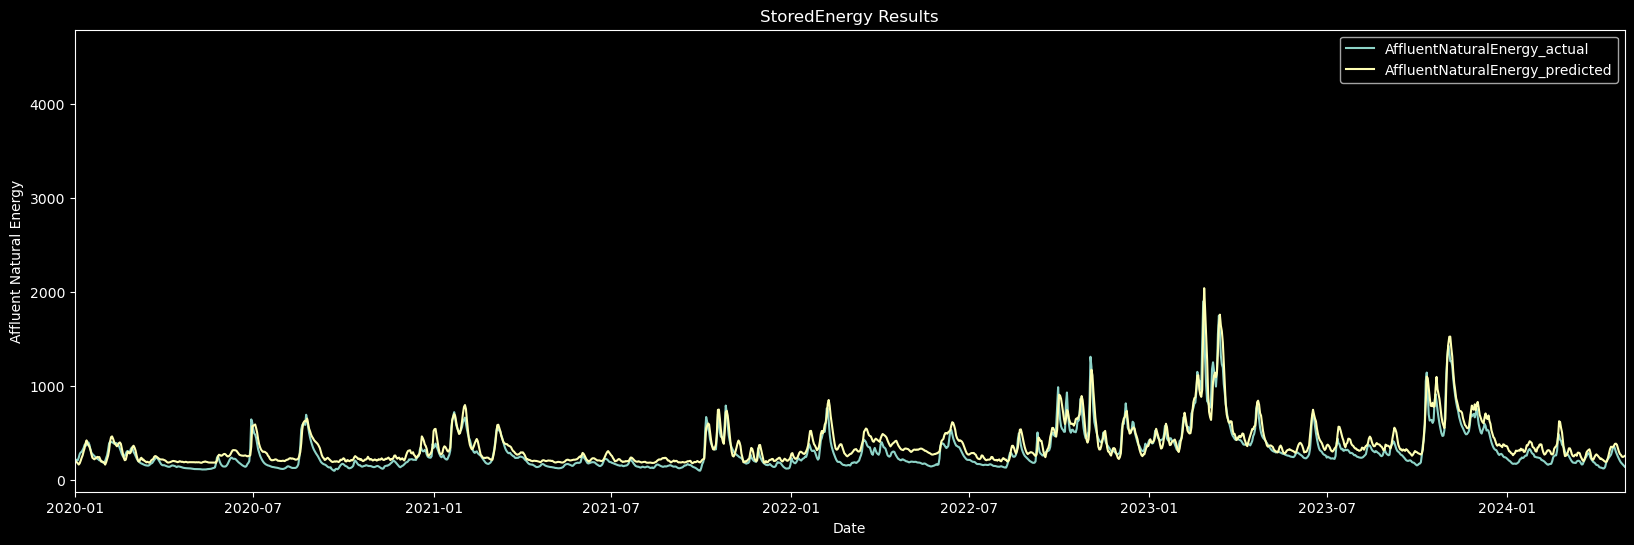

In [144]:
plt.figure(figsize=(20, 6))
plt.plot(result_capivara_df["Date"], 
         result_capivara_df[["AffluentNaturalEnergy_actual", "AffluentNaturalEnergy_predicted"]]
        )
plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2024-04-30'))
plt.xlabel('Date')
plt.ylabel('Affluent Natural Energy')
plt.title('StoredEnergy Results')
plt.legend(["AffluentNaturalEnergy_actual","AffluentNaturalEnergy_predicted" ], loc="upper right")
plt.show()

In [145]:
result_chavantes_df = pd.DataFrame()
result_chavantes_df["Date"] = Series_Chavantes_df["Date"]
result_chavantes_df["AffluentNaturalEnergy_actual"] = Series_Chavantes_df["AffluentNaturalEnergy"]
result_chavantes_df["AffluentNaturalEnergy_predicted"] = df_forecasted_chavantes["AffluentNaturalEnergy_results"]

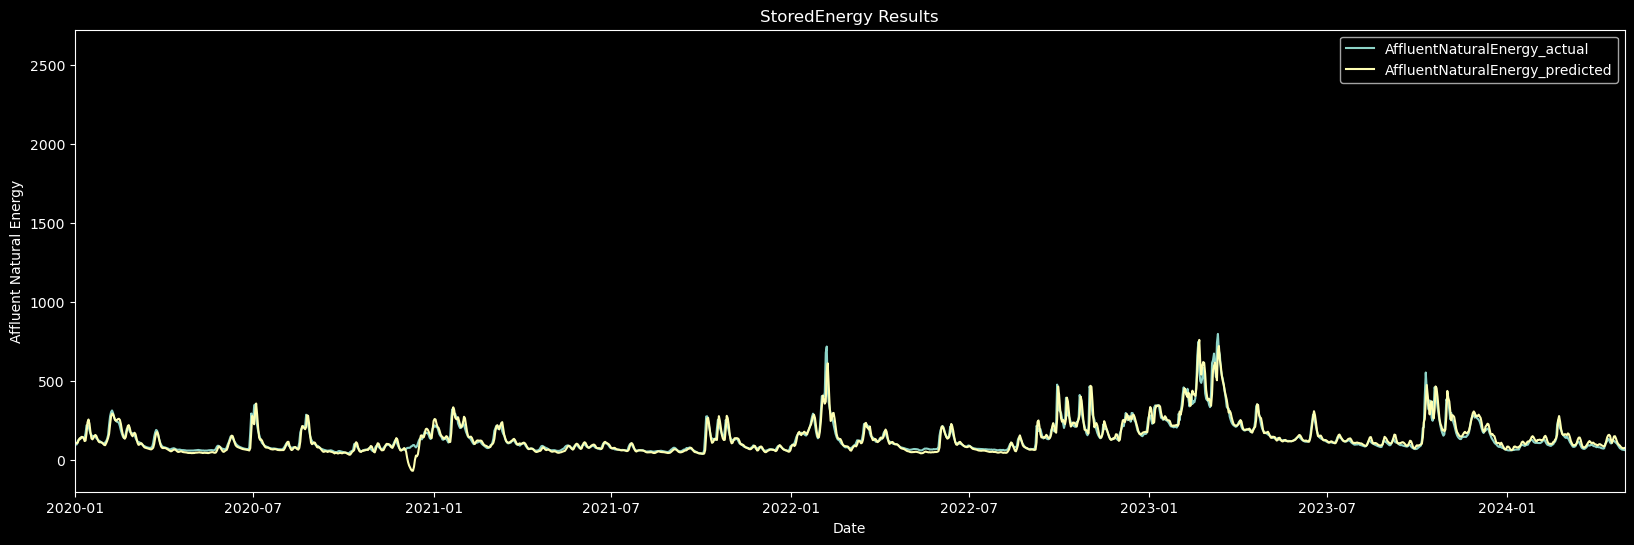

In [146]:
plt.figure(figsize=(20, 6))
plt.plot(result_chavantes_df["Date"], 
         result_chavantes_df[["AffluentNaturalEnergy_actual", "AffluentNaturalEnergy_predicted"]]
        )
plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2024-04-30'))
plt.xlabel('Date')
plt.ylabel('Affluent Natural Energy')
plt.title('StoredEnergy Results')
plt.legend(["AffluentNaturalEnergy_actual","AffluentNaturalEnergy_predicted" ], loc="upper right")
plt.show()

In [147]:
result_jurumirim_df = pd.DataFrame()
result_jurumirim_df["Date"] = Series_Jurumirim_df["Date"]
result_jurumirim_df["AffluentNaturalEnergy_actual"] = Series_Jurumirim_df["AffluentNaturalEnergy"]
result_jurumirim_df["AffluentNaturalEnergy_predicted"] = df_forecasted_jurumirim["AffluentNaturalEnergy_results"]

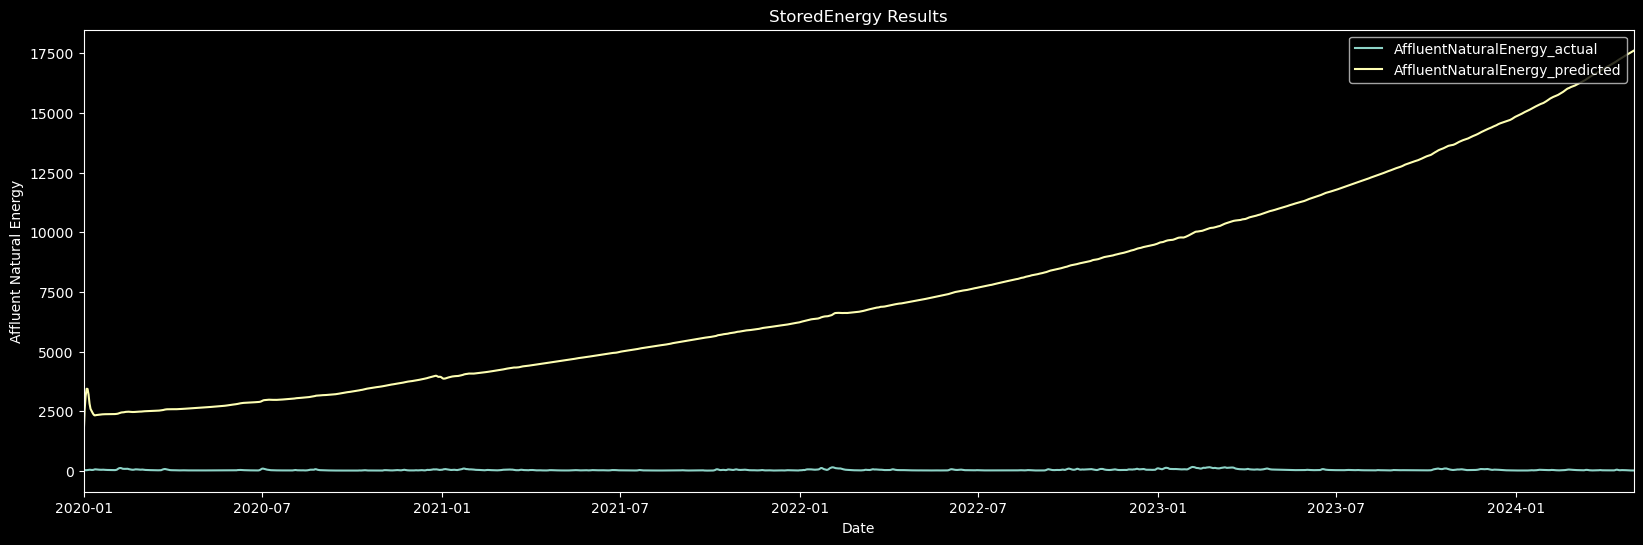

In [148]:
plt.figure(figsize=(20, 6))
plt.plot(result_jurumirim_df["Date"], 
         result_jurumirim_df[["AffluentNaturalEnergy_actual", "AffluentNaturalEnergy_predicted"]]
        )
plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2024-04-30'))
plt.xlabel('Date')
plt.ylabel('Affluent Natural Energy')
plt.title('StoredEnergy Results')
plt.legend(["AffluentNaturalEnergy_actual","AffluentNaturalEnergy_predicted" ], loc="upper right")
plt.show()

# Forecast Hydroloelectrical power energy using LSTM architecture

In [180]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from datetime import datetime as dt
from IPython.display import Image, HTML
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import autocorrelation_plot

from sklearn.metrics import r2_score
import sklearn.metrics as metrics

from arcgis.gis import GIS
from arcgis.learn import TimeSeriesModel, prepare_tabulardata
from arcgis.features import FeatureLayer, FeatureLayerCollection

## One-step multivariate forecasting

### Train - Test split of timeseries dataset

In [181]:
#Capivara
test_size = 1582
Train_capivara, test_capivara = train_test_split(Series_Capivara_df, test_size=test_size, shuffle=False)
#Chavantes
test_size = 1582
Train_chavantes, test_chavantes = train_test_split(Series_Chavantes_df, test_size=test_size, shuffle=False)
#Jurumirim
test_size = 1582
Train_jurumirim, test_jurumirim = train_test_split(Series_Jurumirim_df, test_size=test_size, shuffle=False)

### Autocorrelation plot 

#### Capivara 

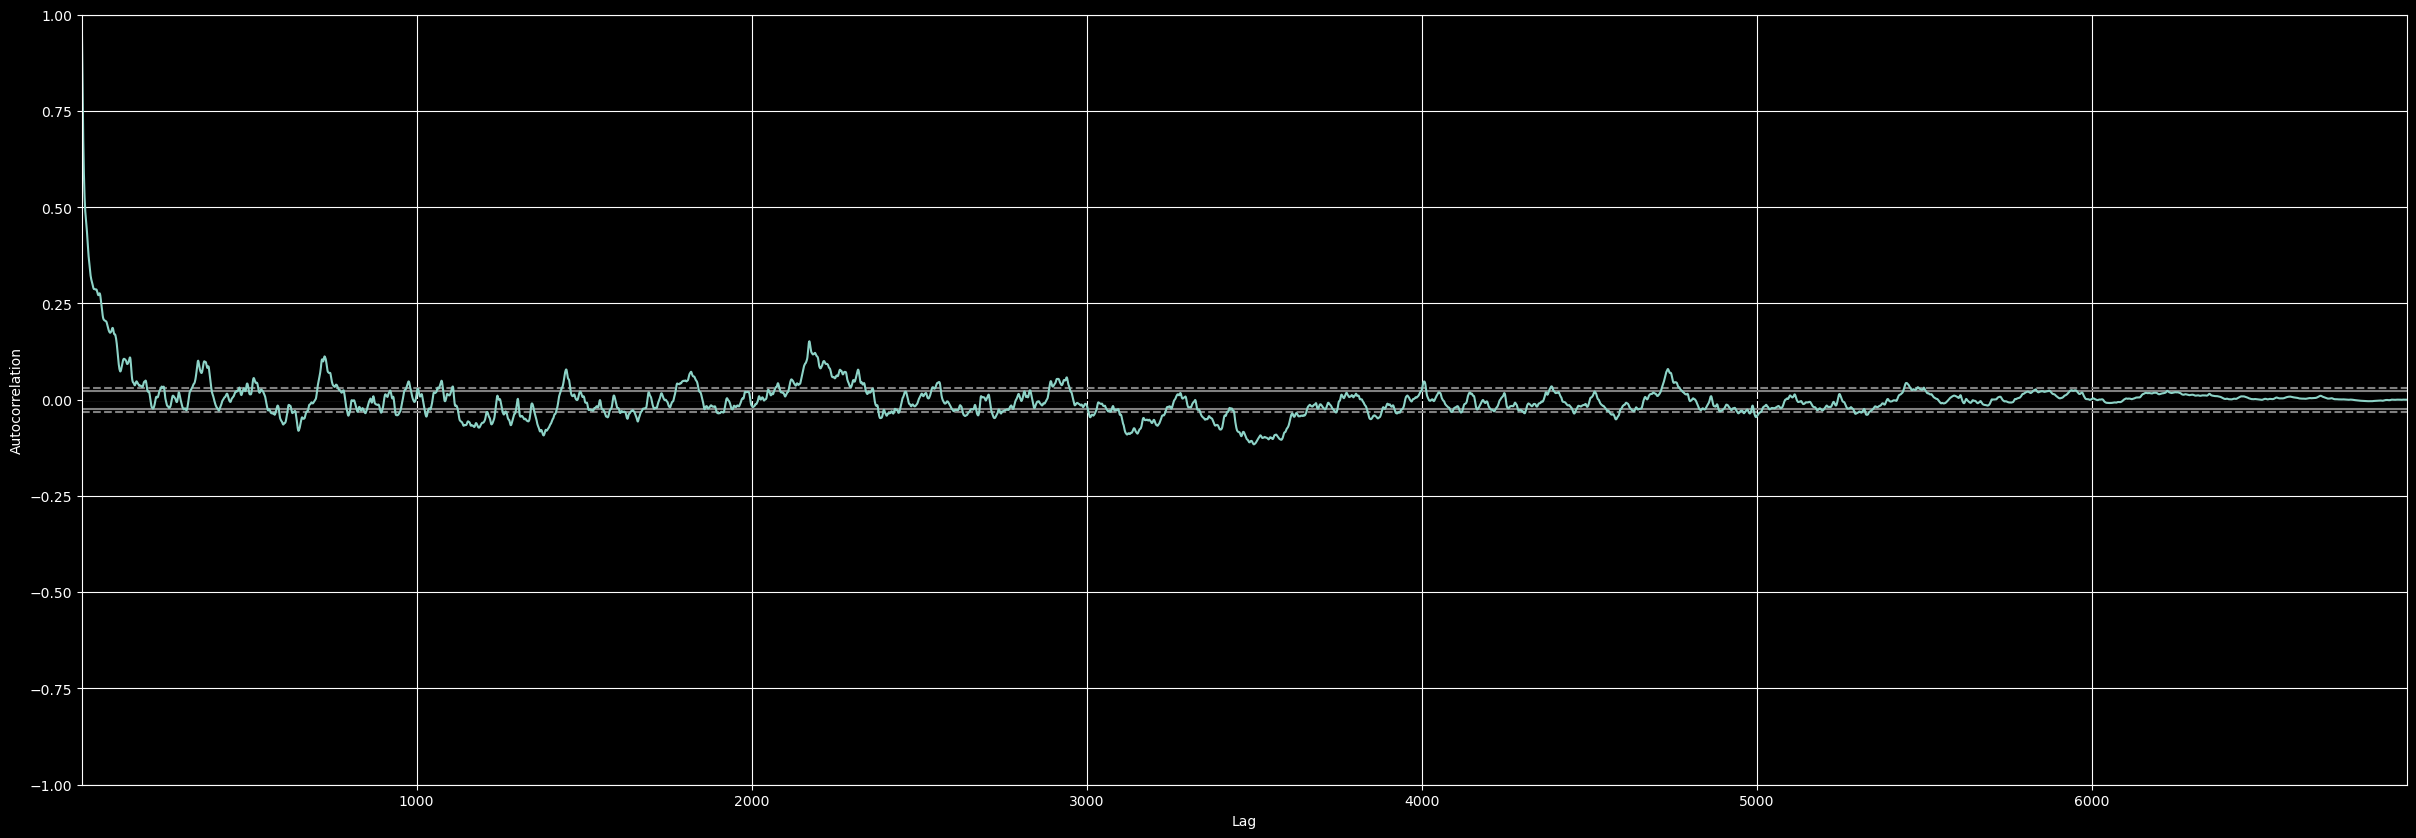

In [151]:
plt.figure(figsize=(30,10))
autocorrelation_plot(Train_capivara["AffluentNaturalEnergy"])
plt.show()

#### Chavantes 

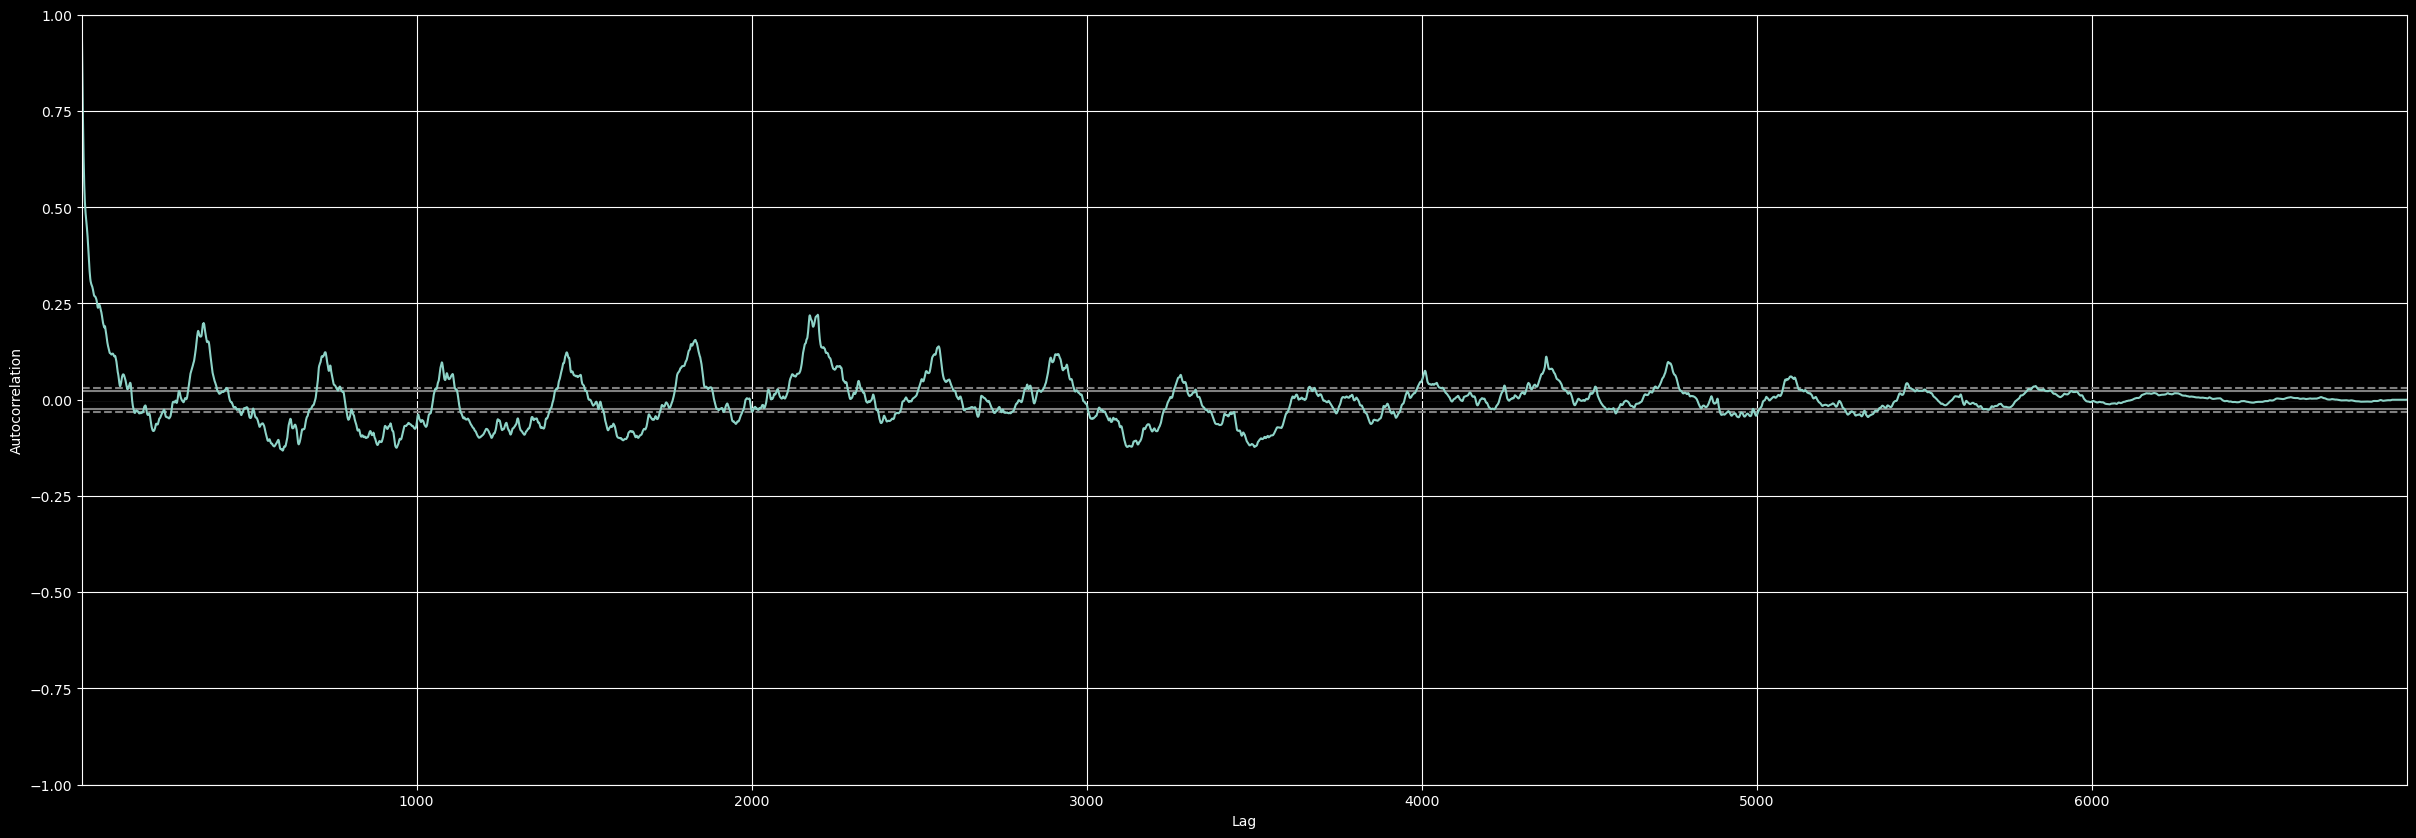

In [152]:
plt.figure(figsize=(30,10))
autocorrelation_plot(Train_chavantes["AffluentNaturalEnergy"])
plt.show()

#### Jurumirim 

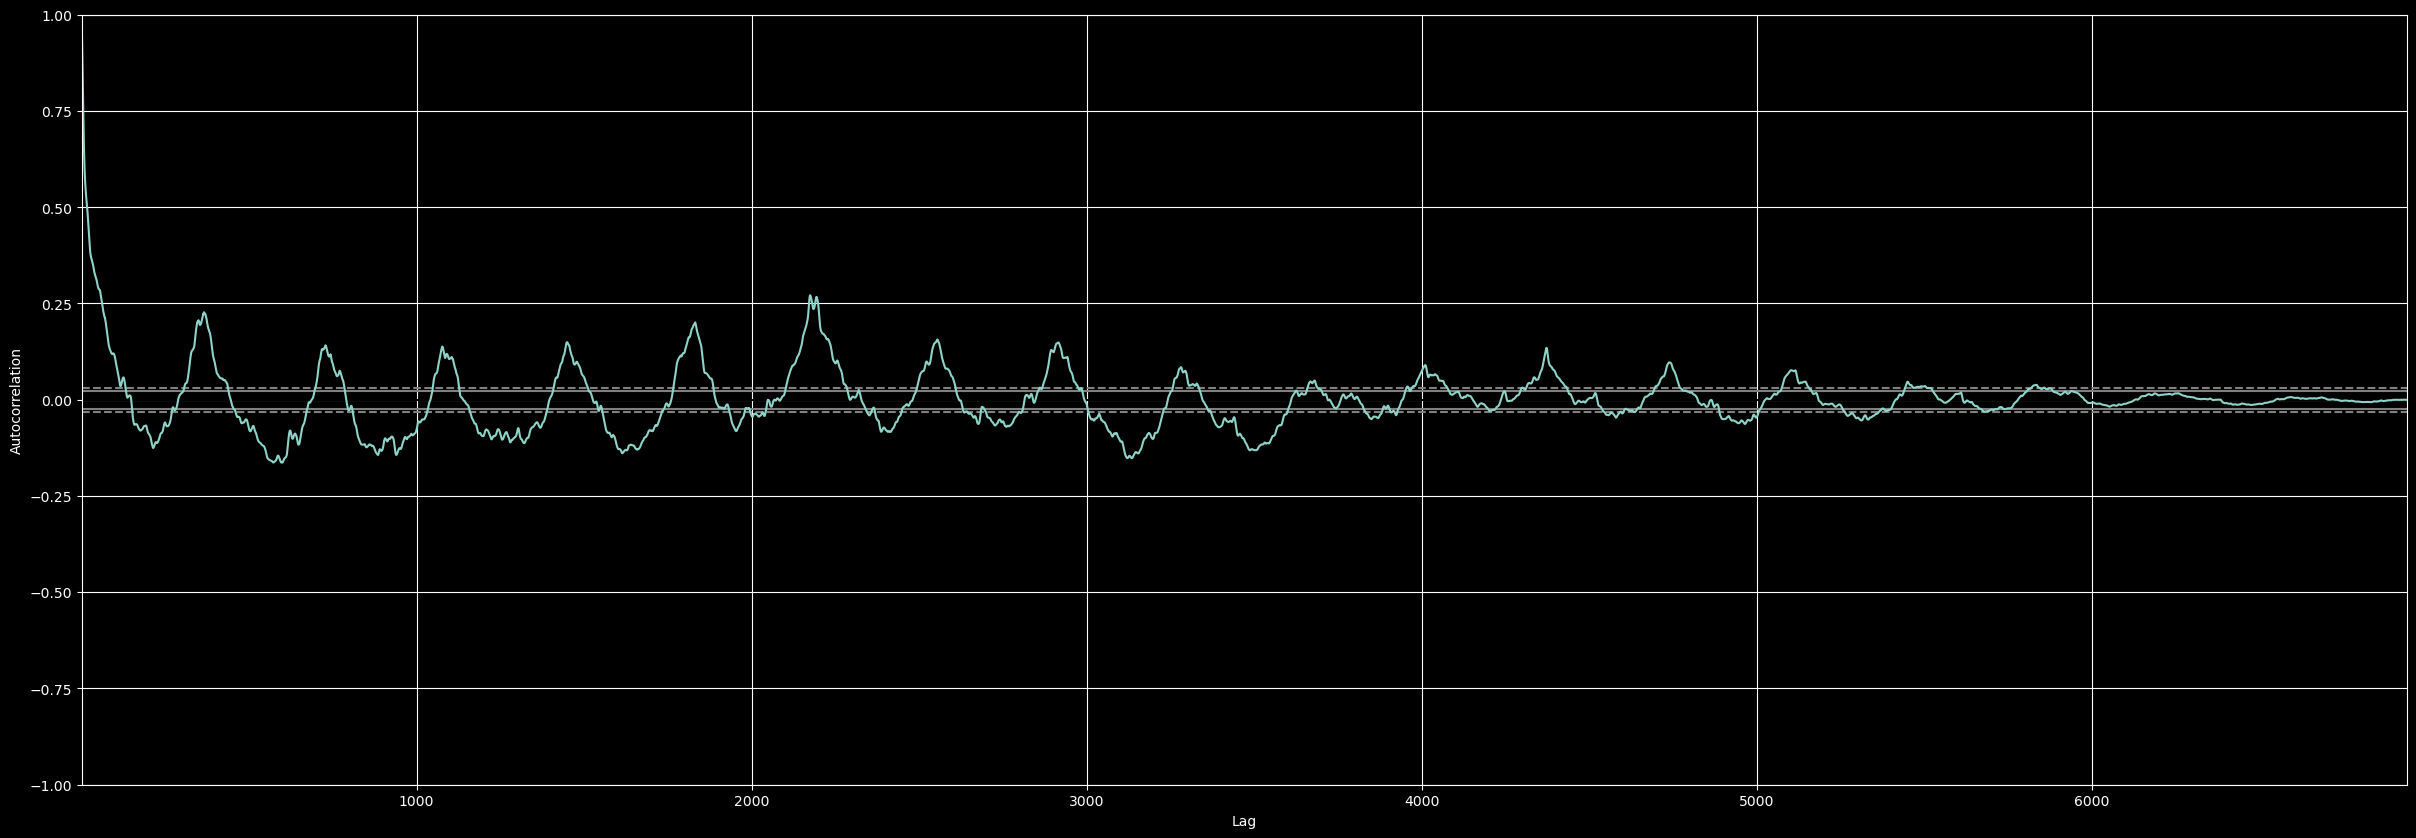

In [153]:
plt.figure(figsize=(30,10))
autocorrelation_plot(Train_jurumirim["AffluentNaturalEnergy"])
plt.show()

## Model building

### Data preparation 

In [154]:
Train_capivara.columns

Index(['AffluentFlow', 'DefluentFlow', 'NaturalFlow', 'AffluentNaturalEnergy',
       'Date'],
      dtype='object')

### One step univariate

In [156]:
preprocessors_capivara = [("AffluentNaturalEnergy", MinMaxScaler())]
data_capivara = prepare_tabulardata(Train_capivara, 
                           variable_predict="AffluentNaturalEnergy",
                           index_field="Date", 
                           preprocessors=preprocessors_capivara)

preprocessors_chavantes = [("AffluentNaturalEnergy", MinMaxScaler())]
data_chavantes = prepare_tabulardata(Train_chavantes, 
                           variable_predict="AffluentNaturalEnergy",
                           index_field="Date", 
                           preprocessors=preprocessors_chavantes)

preprocessors_jurumirim = [("AffluentNaturalEnergy", MinMaxScaler())]
data_jurumirim = prepare_tabulardata(Train_jurumirim, 
                           variable_predict="AffluentNaturalEnergy",
                           index_field="Date", 
                           preprocessors=preprocessors_jurumirim)

C:\Users\57320\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\arcgis\learn\_utils\tabular_data.py:1871: UserWarning:

Dataframe is not spatial, Rasters and distance layers will not work

C:\Users\57320\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\arcgis\learn\_utils\tabular_data.py:1871: UserWarning:

Dataframe is not spatial, Rasters and distance layers will not work

C:\Users\57320\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\arcgis\learn\_utils\tabular_data.py:1871: UserWarning:

Dataframe is not spatial, Rasters and distance layers will not work



### Visualize the entire timeseries data

In [163]:
seq_len = 365

#### Capivara 

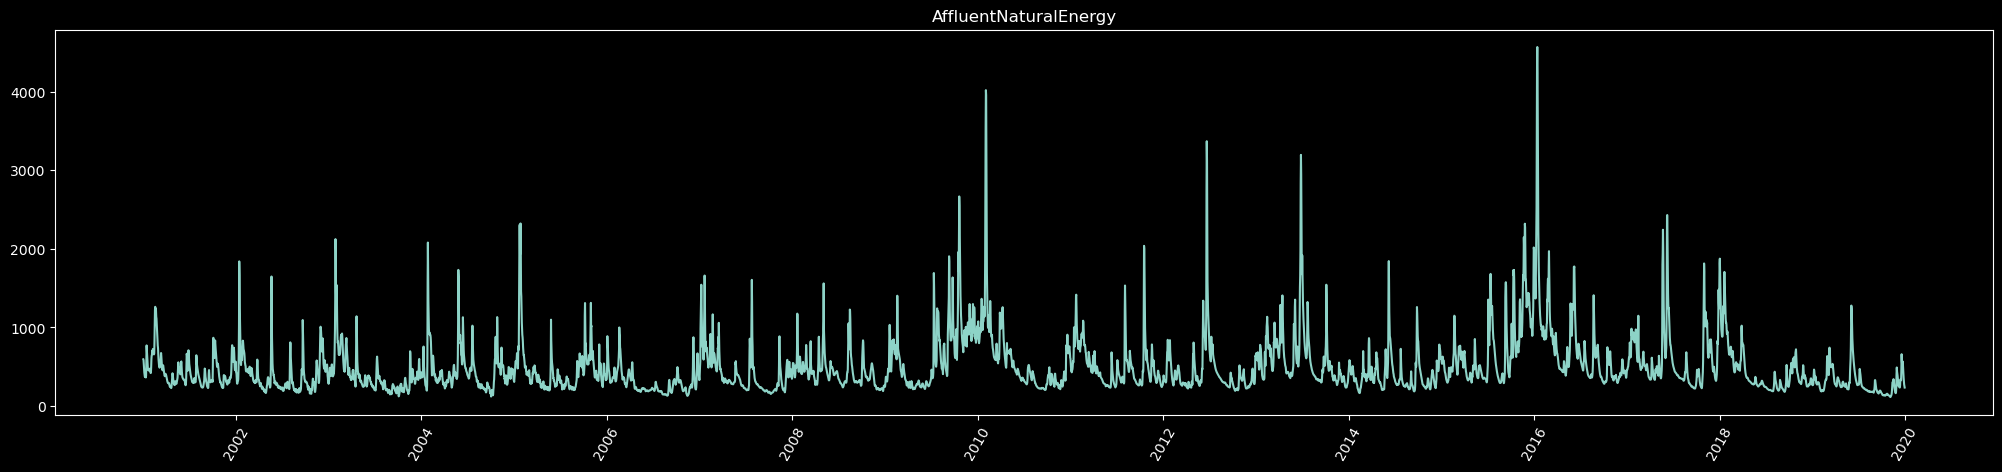

In [157]:
data_capivara.show_batch(graph=True)

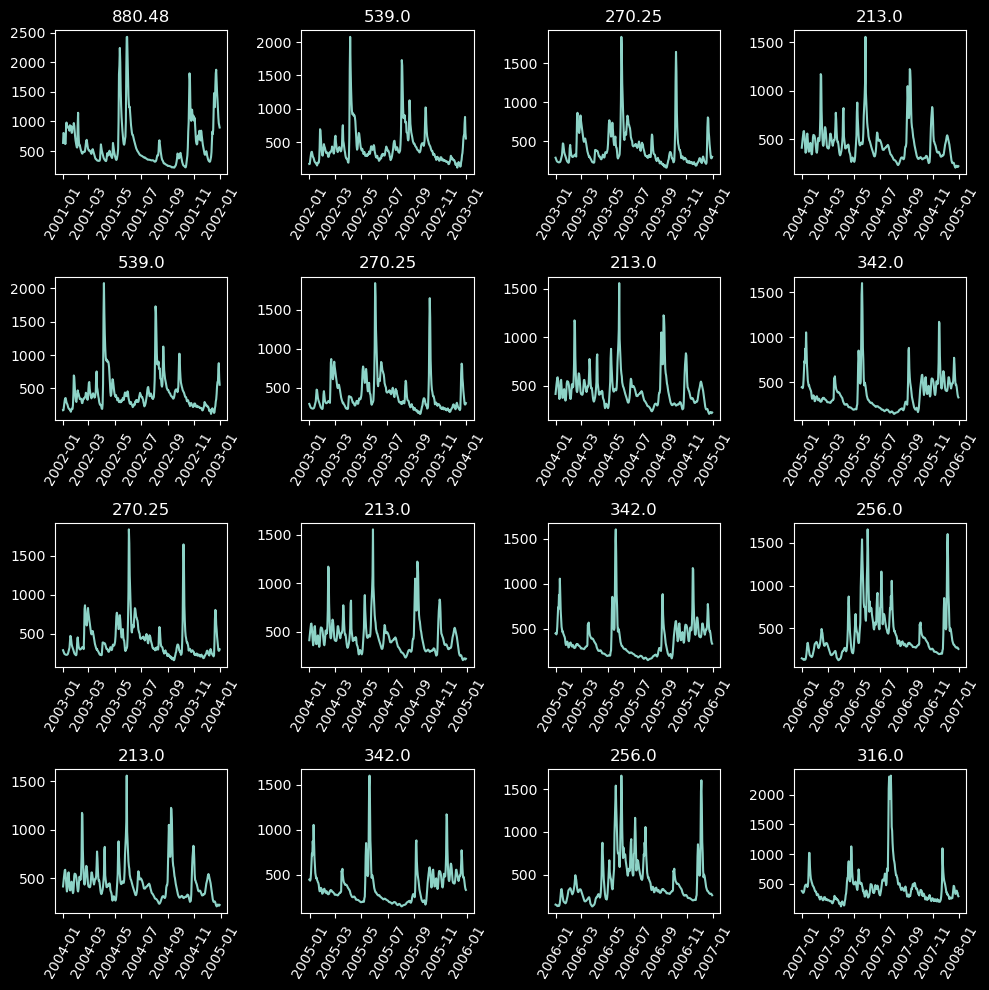

In [164]:
data_capivara.show_batch(rows=4,seq_len=seq_len)

#### Chavantes 

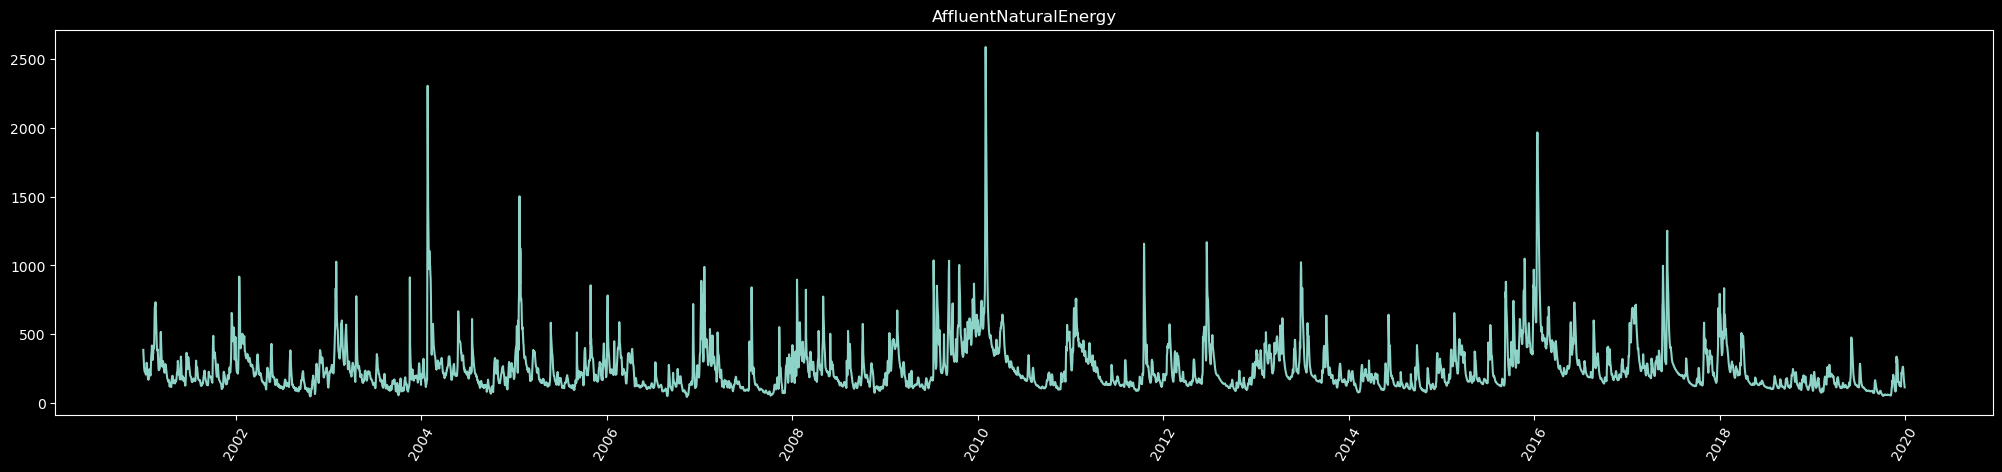

In [158]:
data_chavantes.show_batch(graph=True)

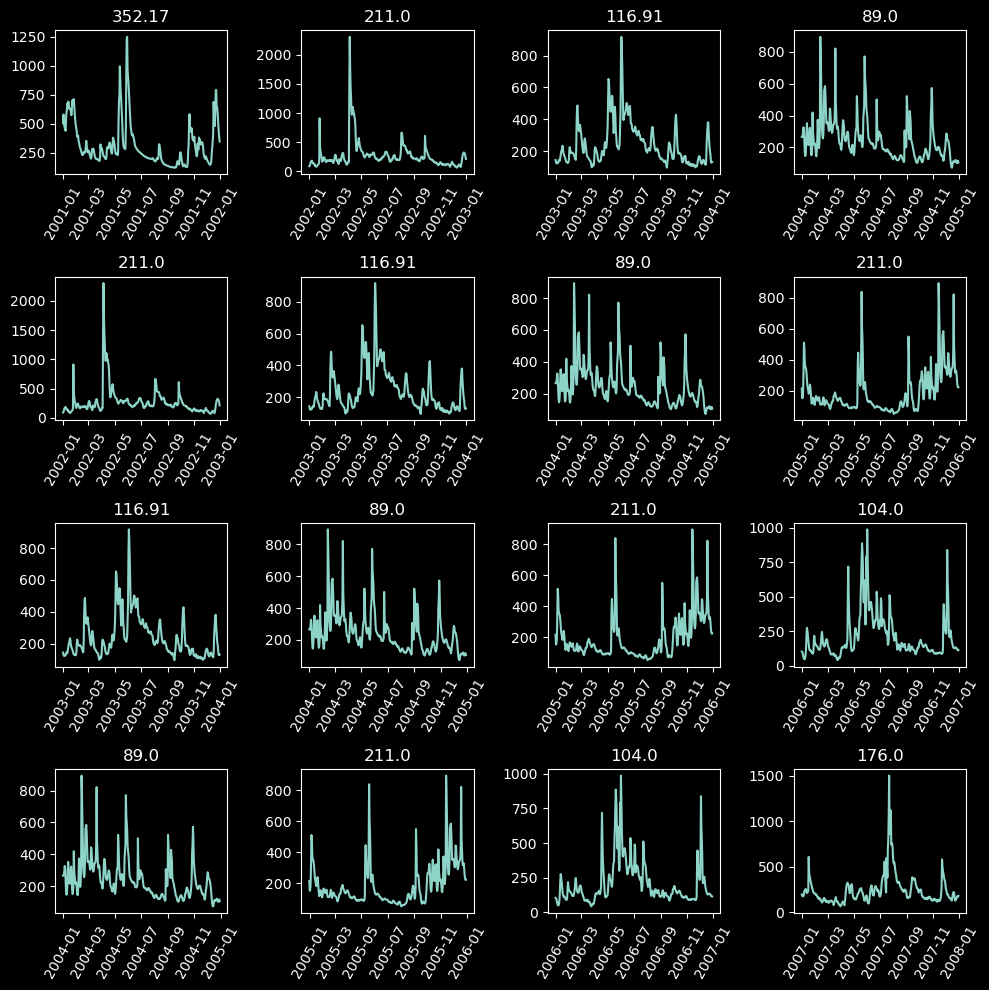

In [165]:
data_chavantes.show_batch(rows=4,seq_len=seq_len)

#### Jurumirim 

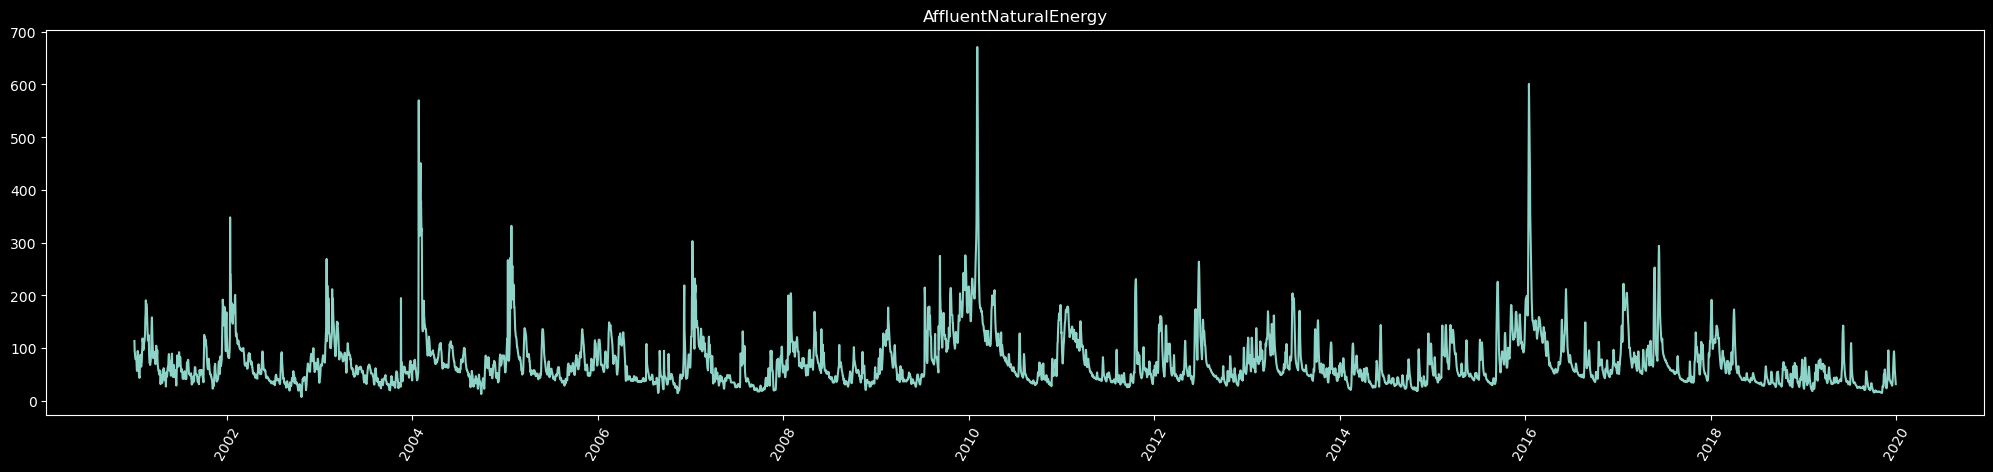

In [159]:
data_jurumirim.show_batch(graph=True)

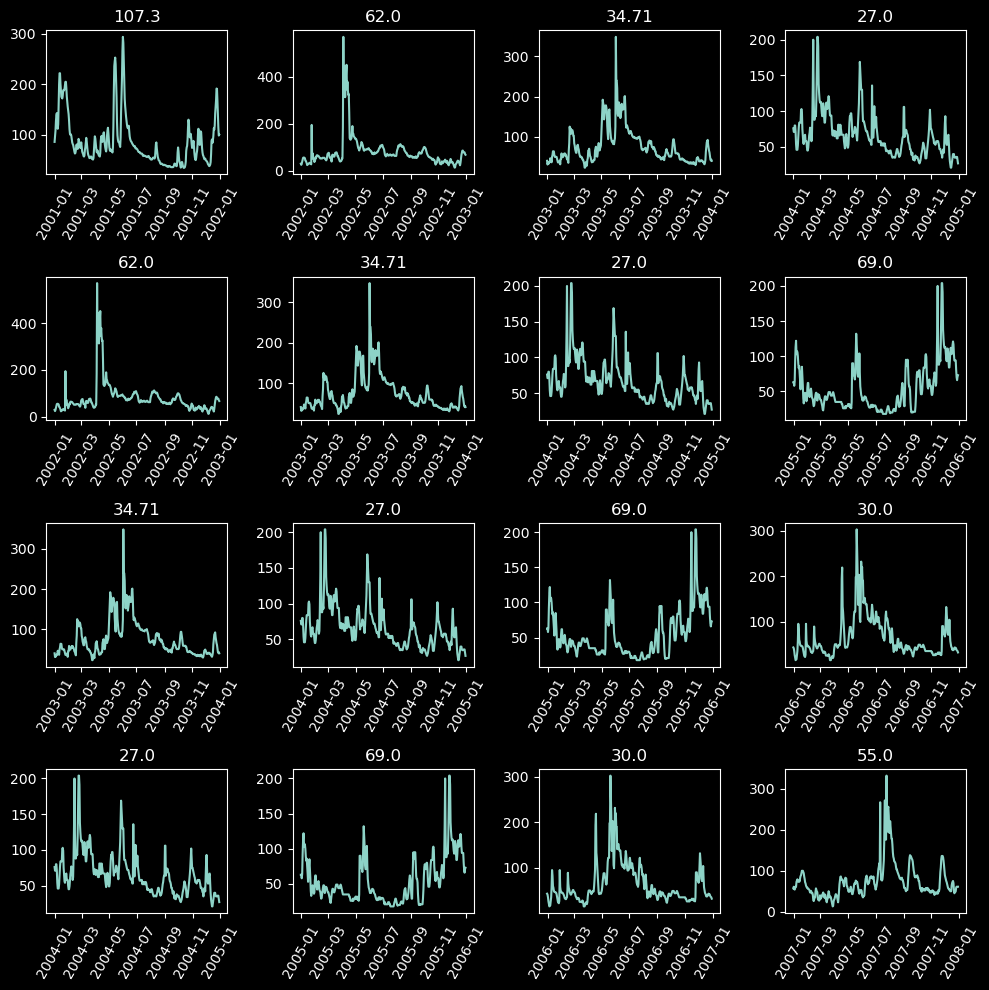

In [166]:
data_jurumirim.show_batch(rows=4,seq_len=seq_len)

## Model initialization

In [167]:
# In model initialization, the data and the backbone is selected 
ts_model_capivara = TimeSeriesModel(data_capivara, seq_len=seq_len, model_arch='LSTM',bidirectional=True)

# In model initialization, the data and the backbone is selected 
ts_model_chavantes = TimeSeriesModel(data_chavantes, seq_len=seq_len, model_arch='LSTM',bidirectional=True)

# In model initialization, the data and the backbone is selected 
ts_model_jurumirim = TimeSeriesModel(data_jurumirim, seq_len=seq_len, model_arch='LSTM',bidirectional=True)

## Learning rate search

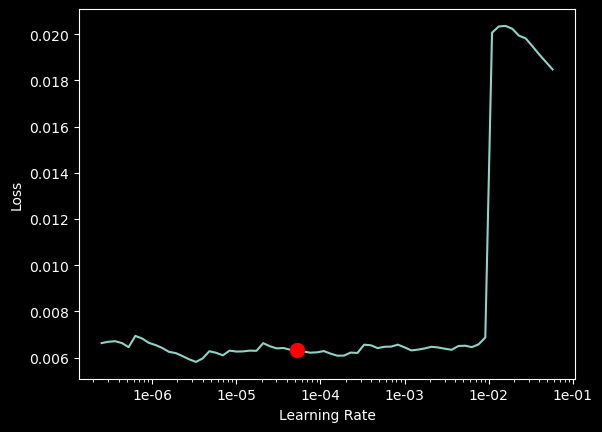

5.248074602497728e-05

In [168]:
l_rate_capivara = ts_model_capivara.lr_find()
l_rate_capivara

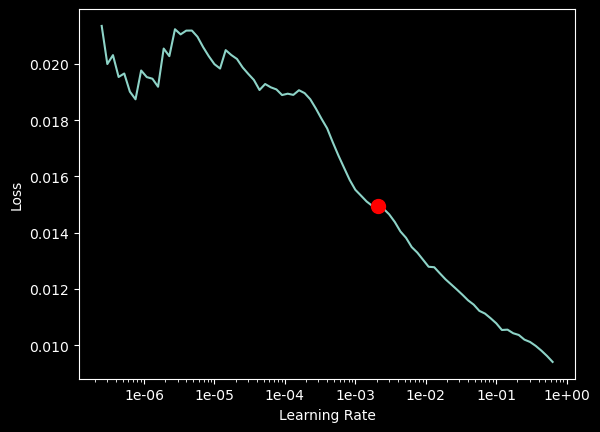

0.0020892961308540407

In [169]:
l_rate_chavantes = ts_model_chavantes.lr_find()
l_rate_chavantes

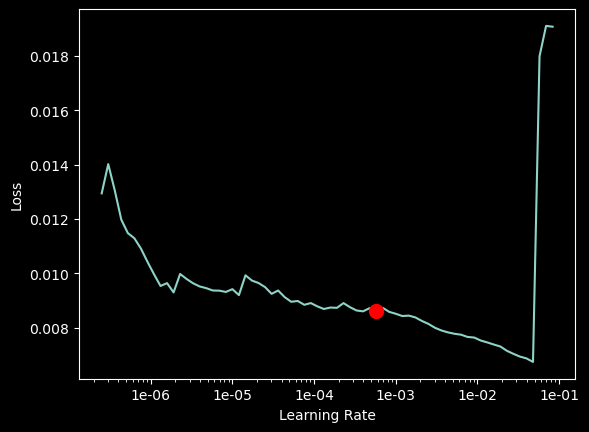

0.0005754399373371565

In [170]:
l_rate_jurumirim = ts_model_jurumirim.lr_find()
l_rate_jurumirim

## Model training 

In [217]:
ts_model_capivara.fit(10, lr=l_rate_capivara)
ts_model_capivara.score()

epoch     train_loss  valid_loss  time    
0         0.002037    0.002014    03:54     
1         0.002009    0.001981    03:17     
2         0.001966    0.001931    03:14     
3         0.002031    0.001884    03:10     
4         0.002001    0.001829    03:17     
5         0.001872    0.001783    03:14     
6         0.001914    0.001757    03:23     
7         0.001623    0.001742    03:28     
8         0.001702    0.001733    03:19     
9         0.001678    0.001732    03:09     


0.6595094742798338

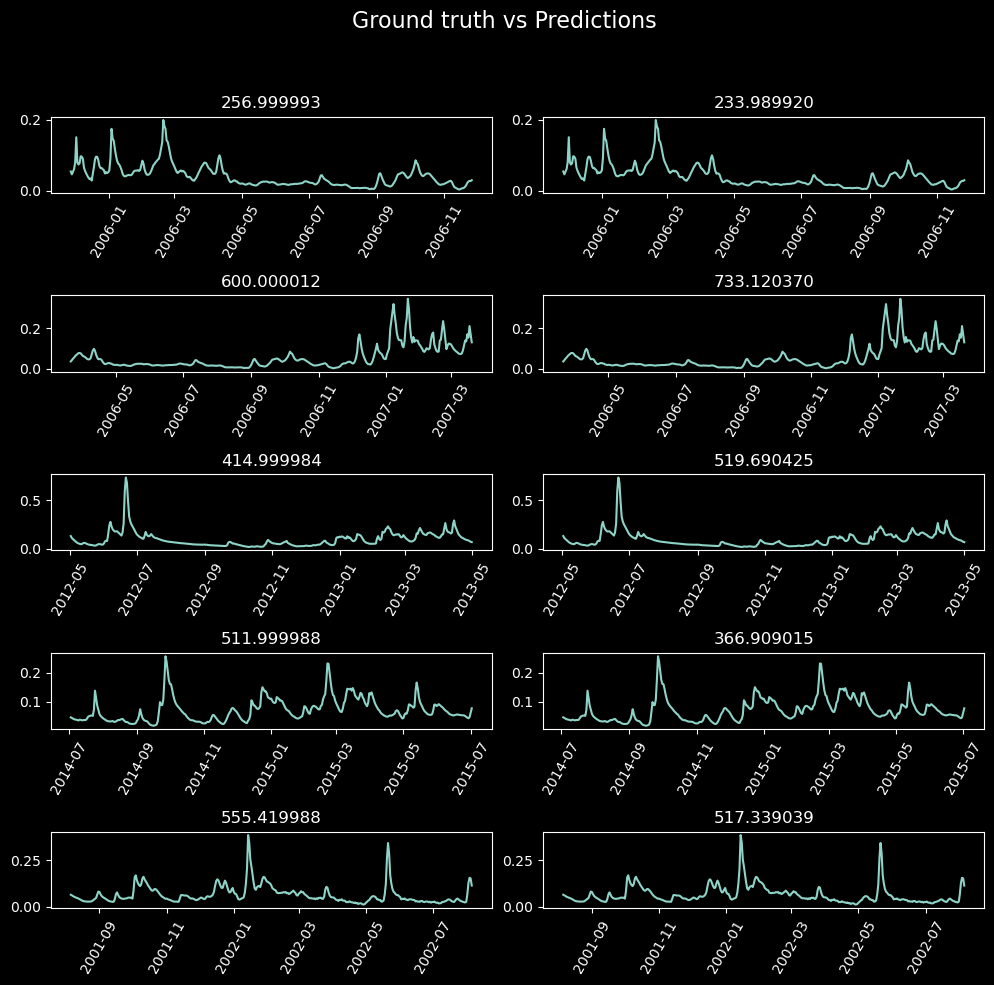

In [172]:
# the ground truth vs the predicted values by the trained model is visualized to check the quality of the trained model
ts_model_capivara.show_results(rows=5)

In [218]:
ts_model_chavantes.fit(10, lr=l_rate_chavantes)
ts_model_chavantes.score()

epoch     train_loss  valid_loss  time    
0         0.000487    0.000337    02:49     
1         0.000479    0.000414    03:33     
2         0.000491    0.000434    03:25     
3         0.000490    0.000349    03:32     
4         0.000480    0.000324    03:28     
5         0.000474    0.000303    03:33     
6         0.000504    0.000370    03:35     
7         0.000462    0.000335    02:52     
8         0.000462    0.000325    01:53     
9         0.000414    0.000326    01:53     


0.9275697672258577

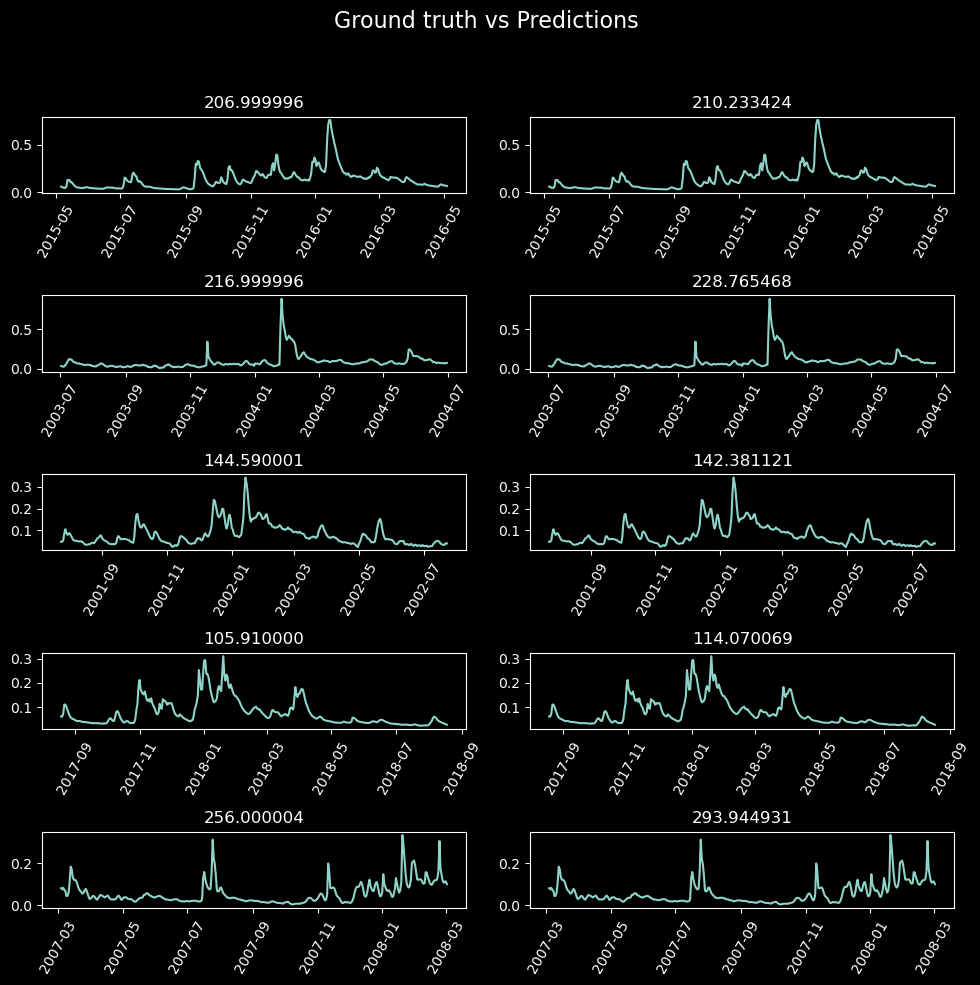

In [174]:
# the ground truth vs the predicted values by the trained model is visualized to check the quality of the trained model
ts_model_chavantes.show_results(rows=5)

In [219]:
ts_model_jurumirim.fit(10, lr=l_rate_jurumirim)
ts_model_jurumirim.score()

epoch     train_loss  valid_loss  time    
0         0.000502    0.000401    01:54     
1         0.000512    0.000405    01:54     
2         0.000474    0.000403    01:54     
3         0.000496    0.000484    01:53     
4         0.000572    0.000434    01:53     
5         0.000488    0.000477    01:53     
6         0.000458    0.000481    01:53     
7         0.000444    0.000509    01:53     
8         0.000438    0.000510    01:53     
9         0.000360    0.000506    01:54     


0.9128399519859037

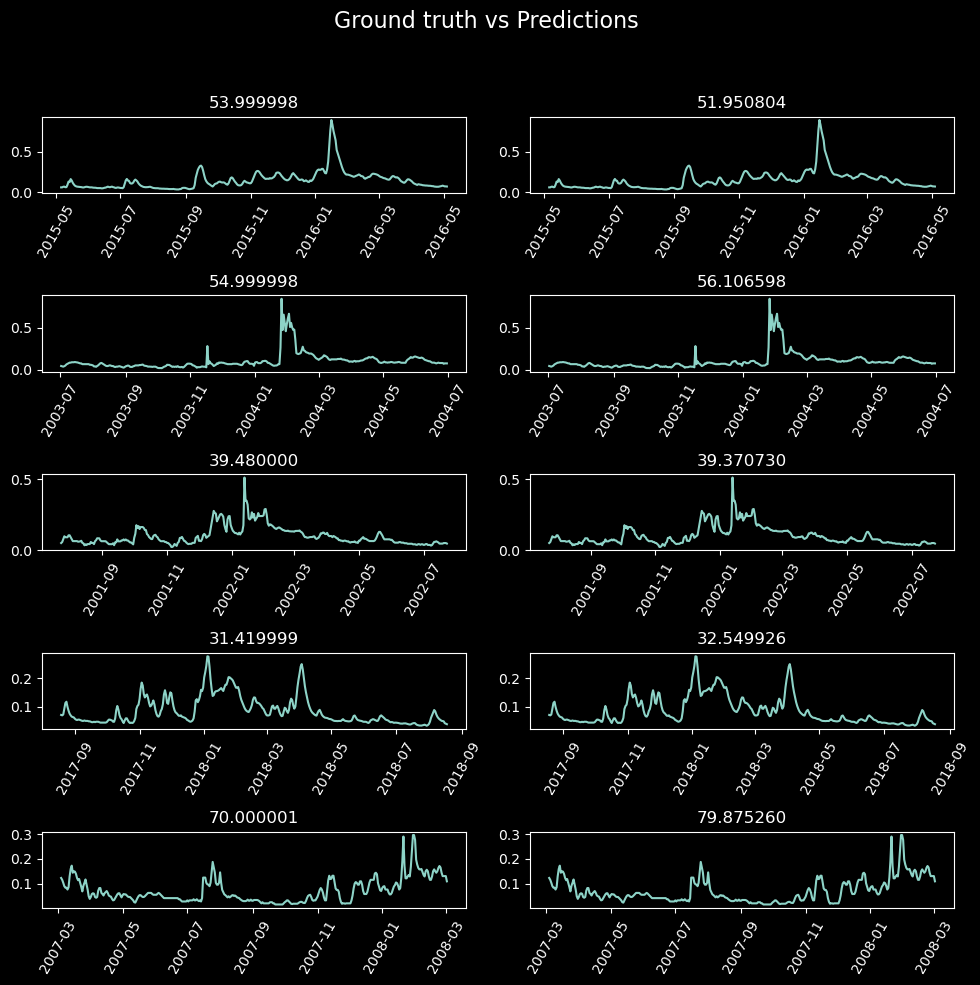

In [176]:
# the ground truth vs the predicted values by the trained model is visualized to check the quality of the trained model
ts_model_jurumirim.show_results(rows=5)

## Forecasting using the trained timeseries model

In [177]:
# Here the forecast is returned as a dataframe, since it is non spatial data, mentioned in the 'prediction_type'  
sdf_forecasted_univar_capivara = ts_model_capivara.predict(Train_capivara, prediction_type='dataframe', number_of_predictions=test_size)

# Here the forecast is returned as a dataframe, since it is non spatial data, mentioned in the 'prediction_type'  
sdf_forecasted_univar_chavantes = ts_model_chavantes.predict(Train_chavantes, prediction_type='dataframe', number_of_predictions=test_size)

# Here the forecast is returned as a dataframe, since it is non spatial data, mentioned in the 'prediction_type'  
sdf_forecasted_univar_jurumirim = ts_model_jurumirim.predict(Train_jurumirim, prediction_type='dataframe', number_of_predictions=test_size)


## Estimate model metric for actual vs. forecast validation

In [210]:
# Formating the forecasted result into actual vs the predicted columns
sdf_forecasted_capivara = sdf_forecasted_univar_capivara.tail(test_size).copy()
sdf_forecasted_capivara = sdf_forecasted_capivara[['Date','AffluentNaturalEnergy_results']]
sdf_forecasted_capivara['Actual_AffluentNaturalEnergy'] = test_capivara['AffluentNaturalEnergy'].values
sdf_forecasted_capivara = sdf_forecasted_capivara.set_index(sdf_forecasted_capivara.columns[0])

# Formating the forecasted result into actual vs the predicted columns
sdf_forecasted_chavantes = sdf_forecasted_univar_chavantes.tail(test_size).copy()
sdf_forecasted_chavantes = sdf_forecasted_chavantes[['Date','AffluentNaturalEnergy_results']]
sdf_forecasted_chavantes['Actual_AffluentNaturalEnergy'] = test_chavantes['AffluentNaturalEnergy'].values
sdf_forecasted_chavantes = sdf_forecasted_chavantes.set_index(sdf_forecasted_chavantes.columns[0])

# Formating the forecasted result into actual vs the predicted columns
sdf_forecasted_jurumirim = sdf_forecasted_univar_jurumirim.tail(test_size).copy()
sdf_forecasted_jurumirim = sdf_forecasted_jurumirim[['Date','AffluentNaturalEnergy_results']]
sdf_forecasted_jurumirim['Actual_AffluentNaturalEnergy'] = test_jurumirim['AffluentNaturalEnergy'].values
sdf_forecasted_jurumirim = sdf_forecasted_jurumirim.set_index(sdf_forecasted_jurumirim.columns[0])


In [192]:
# Bi-LSTM
r2_test_capivara = r2_score(sdf_forecasted_capivara['Actual_AffluentNaturalEnergy'],sdf_forecasted_capivara['AffluentNaturalEnergy_results'])
print('R-Square: ', round(r2_test_capivara, 2))

# Bi-LSTM
r2_test_chavantes = r2_score(sdf_forecasted_chavantes['Actual_AffluentNaturalEnergy'],sdf_forecasted_chavantes['AffluentNaturalEnergy_results'])
print('R-Square: ', round(r2_test_chavantes, 2))

# Bi-LSTM
r2_test_jurumirim = r2_score(sdf_forecasted_jurumirim['Actual_AffluentNaturalEnergy'],sdf_forecasted_jurumirim['AffluentNaturalEnergy_results'])
print('R-Square: ', round(r2_test_jurumirim, 2))

R-Square:  -0.94
R-Square:  -1.7
R-Square:  -0.1


In [201]:
sdf_forecasted_jurumirim

AffluentNaturalEnergy_results  Actual_AffluentNaturalEnergy
Date                                                                   
2020-01-01                      31.406939                         30.30
2020-01-02                      30.879551                         28.74
2020-01-03                      31.410885                         27.53
2020-01-04                      32.224113                         30.01
2020-01-05                      33.100900                         36.29
...                                   ...                           ...
2024-04-26                      31.833116                         20.18
2024-04-27                      31.833064                         18.91
2024-04-28                      31.833022                         18.94
2024-04-29                      31.832968                         18.50
2024-04-30                      31.832908                         18.44

[1582 rows x 2 columns]

## Actual vs. forecast visualization

#### Capivara

In [211]:
#sdf_forecasted = sdf_forecasted.reset_index()
sdf_forecasted_capivara['Date'] = (sdf_forecasted_capivara.index).to_timestamp()
sdf_forecasted_capivara.set_index('Date', inplace=True)

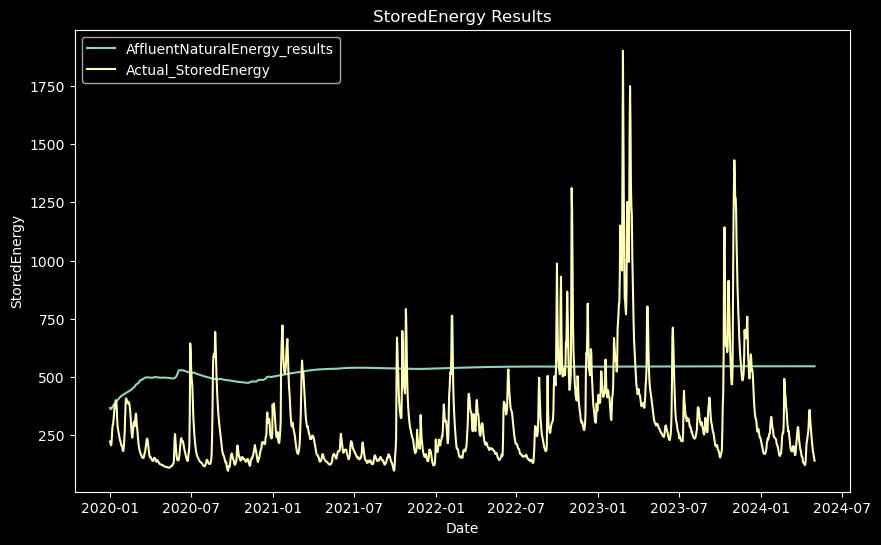

In [212]:
plt.figure(figsize=(10, 6))
plt.plot(sdf_forecasted_capivara.index, sdf_forecasted_capivara['AffluentNaturalEnergy_results'], label='AffluentNaturalEnergy_results')
plt.plot(sdf_forecasted_capivara.index, sdf_forecasted_capivara['Actual_AffluentNaturalEnergy'], label='Actual_StoredEnergy')
plt.xlabel('Date')
plt.ylabel('StoredEnergy')
plt.title('StoredEnergy Results')
plt.legend()
plt.show()

#### Chavantes 

In [213]:
#sdf_forecasted = sdf_forecasted.reset_index()
sdf_forecasted_chavantes['Date'] = (sdf_forecasted_chavantes.index).to_timestamp()
sdf_forecasted_chavantes.set_index('Date', inplace=True)

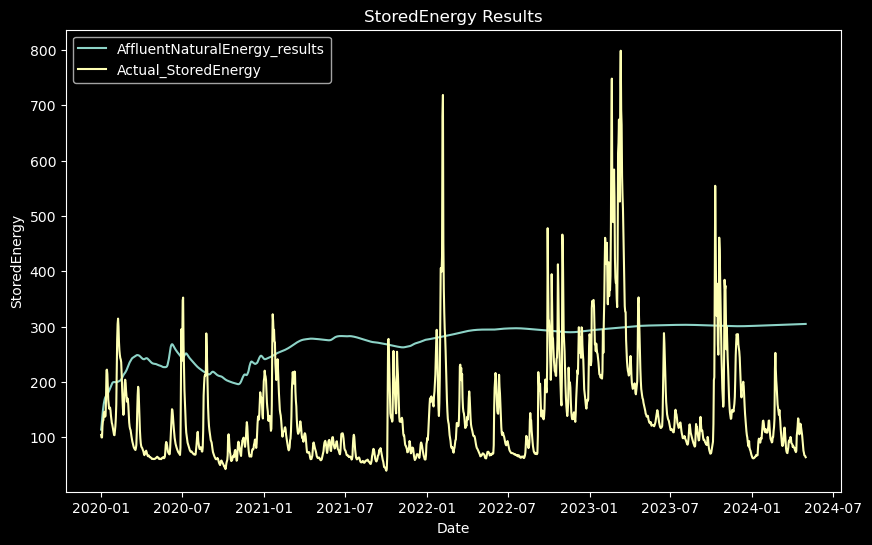

In [214]:
plt.figure(figsize=(10, 6))
plt.plot(sdf_forecasted_chavantes.index, sdf_forecasted_chavantes['AffluentNaturalEnergy_results'], label='AffluentNaturalEnergy_results')
plt.plot(sdf_forecasted_chavantes.index, sdf_forecasted_chavantes['Actual_AffluentNaturalEnergy'], label='Actual_StoredEnergy')
plt.xlabel('Date')
plt.ylabel('StoredEnergy')
plt.title('StoredEnergy Results')
plt.legend()
plt.show()

#### Jurumirim 

In [215]:
#sdf_forecasted = sdf_forecasted.reset_index()
sdf_forecasted_jurumirim['Date'] = (sdf_forecasted_jurumirim.index).to_timestamp()
sdf_forecasted_jurumirim.set_index('Date', inplace=True)

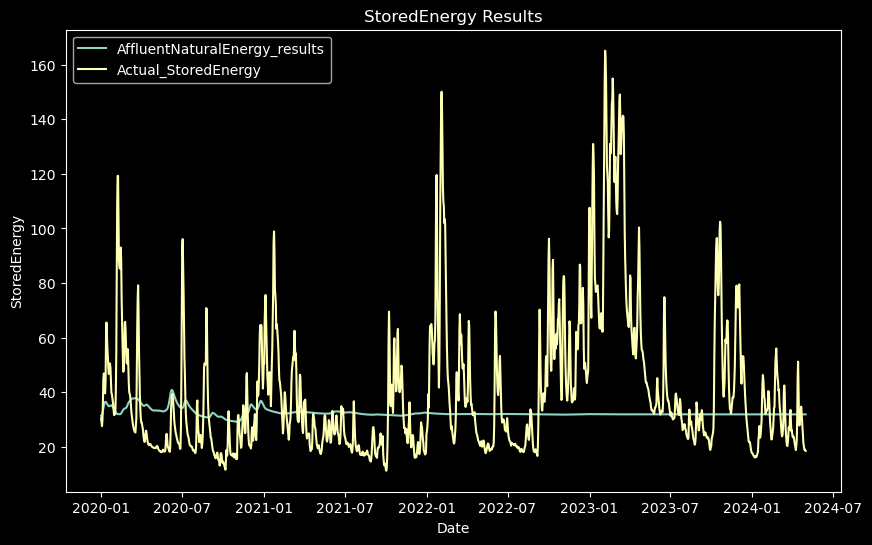

In [216]:
plt.figure(figsize=(10, 6))
plt.plot(sdf_forecasted_jurumirim.index, sdf_forecasted_jurumirim['AffluentNaturalEnergy_results'], label='AffluentNaturalEnergy_results')
plt.plot(sdf_forecasted_jurumirim.index, sdf_forecasted_jurumirim['Actual_AffluentNaturalEnergy'], label='Actual_StoredEnergy')
plt.xlabel('Date')
plt.ylabel('StoredEnergy')
plt.title('StoredEnergy Results')
plt.legend()
plt.show()